In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["LD_LIBRARY_PATH"]="/local/cuda-10.2/lib64"
sys.path.append("/local/cuda-10.2/bin")


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes_masked



# GPU = True
# import os

# if GPU:
#     txt_device = 'gpu:0'
# else:
#     txt_device = 'cpu:0'    
#     os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-21 17:40:03.648994: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-21 17:40:15.138736: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-07-21 17:40:15.182066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-07-21 17:40:15.182110: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-07-21 17:40:15.184653: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-07-21 17:40:15.187000: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

In [2]:
def plot_result(results, start=0, end=-1, node_names=["u", "v"], yscale="log", y_lims=None):
    import matplotlib.pyplot as plt

    def _closing_commands_():
        plt.legend()
        plt.grid()
        plt.xlabel("Iterations")
        plt.yscale(yscale)
        if y_lims is not None:
            plt.ylim(y_lims)
        plt.show()

    _ = plt.figure(figsize=(14, 5))
    plt.title("Training accuracy for observations")
    plt.plot(results["training_obs_accuracy"][start:end], label="accuracy")
    _closing_commands_()

    if np.any([True if k.startswith("loss_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Real Loss")
        plt.plot(results["loss_total"][start:end], label="total")
        for i, name in enumerate(node_names):
            plt.plot(results[f"loss_obs"][start:end, i], label=f"Obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"loss_pde"][start:end, i], label=f"PDE {name}")
        for key in [k for k in results.keys() if k.startswith("loss_extra_")]:
            plt.plot(results[key][start:end], label=f"{key}")

        _closing_commands_()

    if np.any([True if k.startswith("loss_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Regularisd Loss")
        plt.plot(results["loss_regularisd_total"][start:end], label="total")
        if np.any([True if k.startswith("lambda_") else False for k in results.keys()]):
            for i, name in enumerate(node_names):
                plt.plot(
                    results[f"lambda_obs"][start:end, i] * results[f"loss_obs"][start:end, i],
                    label=f"Obs {name}",
                )
            for i, name in enumerate(node_names):
                plt.plot(
                    results[f"lambda_pde"][start:end, i] * results[f"loss_pde"][start:end, i],
                    label=f"PDE {name}",
                )
        _closing_commands_()

    if np.any([True if k.startswith("grads_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title("Gradient Norms")
        for i, name in enumerate(node_names):
            plt.plot(results[f"grads_obs"][start:end, i], label=f"Grad obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"grads_pde"][start:end, i], label=f"Grad PDE {name}")
        _closing_commands_()

    if np.any([True if k.startswith("lambda_") else False for k in results.keys()]):
        _ = plt.figure(figsize=(14, 5))
        plt.title(r"$\lambda$s")
        for i, name in enumerate(node_names):
            plt.plot(results[f"lambda_obs"][start:end, i], label=r"$\lambda$" f" obs {name}")
        for i, name in enumerate(node_names):
            plt.plot(results[f"lambda_pde"][start:end, i], label=r"$\lambda$" f" PDE {name}")
        _closing_commands_()


In [2]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [4]:
df_params.head()

,Va,Vb,Vc,Vd,Ve,Vf,ba,bb,bc,bd,...,kaa,kbd,kce,kda,keb,kee,kfe,mua,mulva,n
0,360.066204,69.840434,33.468912,283.316201,79.328098,35.847305,0.007714,0.009772,0.010261,0.008996,...,2.316063,2.874391,88.732068,9.363779,9.627162,0.275728,5.519184,4.664757,1.485684,2.0
1,271.955874,101.868916,28.546540,347.711607,84.727223,41.786928,0.008341,0.012020,0.013054,0.010064,...,4.883066,3.640181,99.577576,9.439324,7.552942,0.252092,4.607892,2.973656,1.423090,2.0
2,310.495835,79.551016,51.789526,197.624749,51.961358,40.627957,0.010750,0.015593,0.009346,0.013251,...,3.245317,4.944193,34.494922,13.954478,8.398245,0.299176,4.757444,4.151729,1.129469,2.0
3,368.363031,99.843451,51.223075,312.732434,89.436871,49.564425,0.008238,0.010022,0.007271,0.007357,...,2.941270,2.693431,89.807684,10.478264,7.656785,0.347844,6.552310,3.452419,1.213001,2.0
4,252.138904,90.823276,43.880020,293.190760,87.402367,59.800131,0.008995,0.008820,0.007773,0.011784,...,4.101435,3.625196,60.758534,9.479563,10.618988,0.174654,3.911595,4.190837,1.634196,2.0


In [5]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [6]:
ID = 191
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)

##########################
# select a subset of data
t_star = t_star[50::4]
T = len(t_star)
data = data[:, :, :, 50::4]

#maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
#mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])
#for i in range(data.shape[0]):
#    data[i, :, :, :] = 2.0*(data[i, :, :, :] - mins[i])/(maxs[i]-mins[i]) - 1.0

In [7]:
model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])
obs_mask = np.float32(dataset['obs_mask'])
pde_mask = dataset['pde_mask'] > 0
pde_X = pde_X[pde_mask]
pde_mask = np.float32(pde_mask[pde_mask])

In [8]:
layers = [3, 128, 128, 128, 128, 6]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_loss = Circuit2_variant5716(dtype=tf.float32, D_A=df_params.d_A[ID], D_B = df_params.d_B[ID])
model = TINN_multi_nodes_masked(pinn, 
                pde_loss, 
                nodes_n = nodes_n,
                node_names = node_names,
                alpha = 0.5, 
                print_precision=".8f")

In [9]:
results = []
for i in range(20):
    print("========================================================")
    print(f"   ===============  Run Number {i+1}  =================")
    print("========================================================")
    if i%2 == 0:
        r = model.train(epochs = 200,
                      batch_size = 1024,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,#pde_mask,
                      #X_pde =  pde_X,
                      print_interval=25,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False)
    else:
        r = model.train(epochs = 20,
                      batch_size = 1024*8,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,#pde_mask,
                      #X_pde =  pde_X,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True,
                      regularise_int=1
                       )
    results += [r]     

   ===============  Run Number 1  =================

Start of epoch 0


2022-07-21 17:40:39.295405: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-21 17:40:42.953852: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 475.37231445
total loss: 2882.33046627, total regularisd loss (sum of batches): 1141405.30444336
obs A loss: 0.34882516, pde A loss: 4.64717445
obs B loss: 1.78186297, pde B loss: 1.24680728
obs C loss: 3.67688399, pde C loss: 4.60462547
obs D loss: 2707.59275889, pde D loss: 16.70246794
obs E loss: 115.45826599, pde E loss: 1.60290552
obs F loss: 23.37587261, pde F loss: 1.29201444
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 9.98419 b_B: 9.98695 b_C: 9.94382 b_D: 10.33528 
b_E: 10.10405 b_F: 10.03407 V_A: 9.98383 V_B: 10.02757 
V_C: 9.94410 V_D: 10.37378 V_E: 10.16300 V_F: 10.13543 
k_AA: 9.97216 k_BD: 9.65011 k_CE: 10.10940 k_DA: 9.97757 
k_EB: 10.03474 k_EE: 9.83313 k_FE: 10.12003 mu

   ===============  Run Number 2  =================

Start of epoch 0
Training observations acc over epoch: 13.40435219
total loss: 83.59140533, total regularisd loss (sum of batches): 4182.63099670
obs A loss: 0.06693205, pde A loss: 0.00134497
obs B loss: 0.42435720, pde B loss: 0.30956839
obs C loss: 0.35405871, pde C loss: 0.02573768
obs D loss: 69.31748712, pde D loss: 2.38222685
obs E loss: 9.57591734, pde E loss: 0.42206744
obs F loss: 0.68737570, pde F loss: 0.02433238
lambda obs A: 1.00000000, lambda pde A: 1.00000000
lambda obs B: 1.00000000, lambda pde B: 1.00000000
lambda obs C: 1.00000000, lambda pde C: 1.00000000
lambda obs D: 1.00000000, lambda pde D: 1.00000000
lambda obs E: 1.00000000, lambda pde E: 1.00000000
lambda obs F: 1.00000000, lambda pde F: 1.00000000
b_A: 0.00000 b_B: 0.00000 b_C: 0.09408 b_D: 0.00000 
b_E: 0.07457 b_F: 0.00000 V_A: 0.00079 V_B: 2.35254 
V_C: 0.00000 V_D: 57.08149 V_E: 22.31404 V_F: 5.71140 
k_AA: 13.06696 k_BD: 3.12505 k_CE: 3.62180 k_DA: 5.

Training observations acc over epoch: 13.89324188
total loss: 87.43361771, total regularisd loss (sum of batches): 34986.38214111
obs A loss: 0.06992365, pde A loss: 0.01106434
obs B loss: 0.50891380, pde B loss: 0.34343481
obs C loss: 0.35810378, pde C loss: 0.02528099
obs D loss: 71.71254617, pde D loss: 3.17342125
obs E loss: 10.00029979, pde E loss: 0.49019814
obs F loss: 0.70966975, pde F loss: 0.03076175
lambda obs A: 0.00847700, lambda pde A: 0.00393878
lambda obs B: 0.06417952, lambda pde B: 0.02808973
lambda obs C: 0.13205707, lambda pde C: 0.00735418
lambda obs D: 9.33296394, lambda pde D: 0.40914416
lambda obs E: 1.82718635, lambda pde E: 0.08251473
lambda obs F: 0.09638935, lambda pde F: 0.00770544
b_A: 0.00001 b_B: 0.00000 b_C: 0.09302 b_D: 0.00046 
b_E: 0.03705 b_F: 0.00000 V_A: 0.00247 V_B: 2.35130 
V_C: 0.00000 V_D: 57.25240 V_E: 22.30699 V_F: 5.73753 
k_AA: 13.06819 k_BD: 3.08082 k_CE: 3.58202 k_DA: 5.20279 
k_EB: 23.81267 k_EE: 9.91488 k_FE: 4.35536 mu_A: 0.00000 
mul

Training observations acc over epoch: 13.07061577
total loss: 82.59237134, total regularisd loss (sum of batches): 32732.24829102
obs A loss: 0.07098496, pde A loss: 0.04160911
obs B loss: 0.62538129, pde B loss: 0.35741038
obs C loss: 0.35472682, pde C loss: 0.02423805
obs D loss: 67.10971636, pde D loss: 3.17647787
obs E loss: 9.59650985, pde E loss: 0.53844035
obs F loss: 0.66636957, pde F loss: 0.03050719
lambda obs A: 0.00430802, lambda pde A: 0.00022581
lambda obs B: 0.06869245, lambda pde B: 0.02077692
lambda obs C: 0.10637636, lambda pde C: 0.00300348
lambda obs D: 9.41657257, lambda pde D: 0.39084017
lambda obs E: 1.83071077, lambda pde E: 0.06095685
lambda obs F: 0.09377639, lambda pde F: 0.00376042
b_A: 0.00003 b_B: 0.00000 b_C: 0.09213 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.00260 V_B: 2.34857 
V_C: 0.00000 V_D: 57.40821 V_E: 22.27195 V_F: 5.73901 
k_AA: 13.07091 k_BD: 3.03236 k_CE: 3.51250 k_DA: 5.20280 
k_EB: 23.81332 k_EE: 9.92686 k_FE: 4.27893 mu_A: 0.00000 
mulv


Start of epoch 100
Training observations acc over epoch: 12.57043839
total loss: 82.62680580, total regularisd loss (sum of batches): 243715.31118774
obs A loss: 0.06669385, pde A loss: 0.52906993
obs B loss: 1.48579274, pde B loss: 0.80610343
obs C loss: 0.36768157, pde C loss: 0.01742546
obs D loss: 63.37462087, pde D loss: 4.92983847
obs E loss: 9.48060963, pde E loss: 0.87102971
obs F loss: 0.64723644, pde F loss: 0.05070376
lambda obs A: 0.00454758, lambda pde A: 0.00052214
lambda obs B: 0.07839285, lambda pde B: 0.02017747
lambda obs C: 0.10862418, lambda pde C: 0.00302158
lambda obs D: 9.40842438, lambda pde D: 0.41820273
lambda obs E: 1.79864597, lambda pde E: 0.06169268
lambda obs F: 0.09375381, lambda pde F: 0.00399508
b_A: 0.00043 b_B: 0.00000 b_C: 0.02650 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.00927 V_B: 0.90540 
V_C: 0.00000 V_D: 66.85063 V_E: 26.24639 V_F: 6.63169 
k_AA: 14.26413 k_BD: 3.74143 k_CE: 1.61109 k_DA: 5.26224 
k_EB: 25.59641 k_EE: 11.94104 k_FE: 2.188

Training observations acc over epoch: 8.62874222
total loss: 59.47416908, total regularisd loss (sum of batches): 18854.79864502
obs A loss: 0.06546373, pde A loss: 0.05810699
obs B loss: 1.30726387, pde B loss: 1.13968044
obs C loss: 0.34655360, pde C loss: 0.01908583
obs D loss: 42.18471906, pde D loss: 5.46353795
obs E loss: 7.41949576, pde E loss: 0.96485022
obs F loss: 0.44895251, pde F loss: 0.05645910
lambda obs A: 0.00542239, lambda pde A: 0.00006112
lambda obs B: 0.27253252, lambda pde B: 0.03737057
lambda obs C: 0.18723068, lambda pde C: 0.00254908
lambda obs D: 8.37323475, lambda pde D: 0.72965729
lambda obs E: 2.20068979, lambda pde E: 0.11196774
lambda obs F: 0.07175931, lambda pde F: 0.00752427
b_A: 0.00000 b_B: 0.00000 b_C: 0.02752 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.00769 V_B: 0.85286 
V_C: 0.00000 V_D: 73.71674 V_E: 29.03033 V_F: 7.33119 
k_AA: 14.32848 k_BD: 4.08934 k_CE: 1.59989 k_DA: 5.22421 
k_EB: 26.97053 k_EE: 12.79507 k_FE: 2.12658 mu_A: 0.00000 
mulv

Training observations acc over epoch: 8.64820290
total loss: 59.62343687, total regularisd loss (sum of batches): 18355.54647827
obs A loss: 0.06523961, pde A loss: 0.07108372
obs B loss: 1.25934469, pde B loss: 1.12275106
obs C loss: 0.34428460, pde C loss: 0.01936269
obs D loss: 42.33962539, pde D loss: 5.50566718
obs E loss: 7.42042849, pde E loss: 0.95785479
obs F loss: 0.46030427, pde F loss: 0.05749094
lambda obs A: 0.00574872, lambda pde A: 0.00007963
lambda obs B: 0.27560753, lambda pde B: 0.03603090
lambda obs C: 0.19823432, lambda pde C: 0.00264809
lambda obs D: 8.16004753, lambda pde D: 0.83210891
lambda obs E: 2.28690863, lambda pde E: 0.12416920
lambda obs F: 0.06970553, lambda pde F: 0.00871108
b_A: 0.00000 b_B: 0.00000 b_C: 0.02886 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.02009 V_B: 0.88611 
V_C: 0.00000 V_D: 73.90327 V_E: 29.11775 V_F: 7.35000 
k_AA: 14.29497 k_BD: 4.08370 k_CE: 1.68591 k_DA: 5.22732 
k_EB: 26.96190 k_EE: 12.75130 k_FE: 2.14496 mu_A: 0.00000 
mulv

Training observations acc over epoch: 12.22180080
total loss: 81.63948365, total regularisd loss (sum of batches): 210044.11315918
obs A loss: 0.06526990, pde A loss: 0.09328379
obs B loss: 1.28427092, pde B loss: 1.16673400
obs C loss: 0.36701699, pde C loss: 0.01963709
obs D loss: 61.61325485, pde D loss: 5.94437411
obs E loss: 9.33979007, pde E loss: 1.02234335
obs F loss: 0.66123079, pde F loss: 0.06227806
lambda obs A: 0.00594401, lambda pde A: 0.00008050
lambda obs B: 0.28071123, lambda pde B: 0.03870875
lambda obs C: 0.20144783, lambda pde C: 0.00290755
lambda obs D: 8.17480469, lambda pde D: 0.82290423
lambda obs E: 2.26869345, lambda pde E: 0.12459073
lambda obs F: 0.07057741, lambda pde F: 0.00862865
b_A: 0.00000 b_B: 0.00024 b_C: 0.02805 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.02768 V_B: 0.94533 
V_C: 0.00000 V_D: 74.14366 V_E: 29.16508 V_F: 7.30545 
k_AA: 14.23478 k_BD: 4.16408 k_CE: 1.74212 k_DA: 5.23647 
k_EB: 26.99236 k_EE: 12.80147 k_FE: 2.06830 mu_A: 0.00000 
mu

   ===============  Run Number 6  =================

Start of epoch 0
Training observations acc over epoch: 8.10221004
total loss: 58.96707144, total regularisd loss (sum of batches): 17282.63790894
obs A loss: 0.06587302, pde A loss: 1.00442097
obs B loss: 0.82647027, pde B loss: 1.94053154
obs C loss: 0.33613750, pde C loss: 0.02302932
obs D loss: 39.59992701, pde D loss: 6.22804561
obs E loss: 7.34545768, pde E loss: 1.09663261
obs F loss: 0.43939808, pde F loss: 0.06114771
lambda obs A: 0.00594401, lambda pde A: 0.00008050
lambda obs B: 0.28071123, lambda pde B: 0.03870875
lambda obs C: 0.20144783, lambda pde C: 0.00290755
lambda obs D: 8.17480469, lambda pde D: 0.82290423
lambda obs E: 2.26869345, lambda pde E: 0.12459073
lambda obs F: 0.07057741, lambda pde F: 0.00862865
b_A: 0.00000 b_B: 0.00000 b_C: 0.04595 b_D: 0.00000 
b_E: 0.00117 b_F: 0.00000 V_A: 0.02389 V_B: 1.77714 
V_C: 0.00000 V_D: 86.66323 V_E: 31.48640 V_F: 8.53842 
k_AA: 13.41027 k_BD: 5.24554 k_CE: 2.06807 k_DA: 5.

Training observations acc over epoch: 7.37991810
total loss: 53.58849469, total regularisd loss (sum of batches): 15200.10452271
obs A loss: 0.06581513, pde A loss: 0.07076263
obs B loss: 0.84046064, pde B loss: 1.96469370
obs C loss: 0.33151628, pde C loss: 0.02361468
obs D loss: 35.68610728, pde D loss: 6.08563595
obs E loss: 6.95650048, pde E loss: 1.10346409
obs F loss: 0.39911347, pde F loss: 0.06081047
lambda obs A: 0.00672746, lambda pde A: 0.00007567
lambda obs B: 0.19842233, lambda pde B: 0.06104251
lambda obs C: 0.23899496, lambda pde C: 0.00353739
lambda obs D: 7.97358370, lambda pde D: 0.74931836
lambda obs E: 2.54335785, lambda pde E: 0.13813794
lambda obs F: 0.07907958, lambda pde F: 0.00772184
b_A: 0.00000 b_B: 0.00000 b_C: 0.04542 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.02787 V_B: 1.74370 
V_C: 0.00000 V_D: 86.76578 V_E: 31.51748 V_F: 8.57428 
k_AA: 13.44378 k_BD: 5.20866 k_CE: 2.05458 k_DA: 5.98768 
k_EB: 25.85654 k_EE: 13.01965 k_FE: 2.53480 mu_A: 0.00000 
mulv

Training observations acc over epoch: 7.40423012
total loss: 53.86391720, total regularisd loss (sum of batches): 15294.62924194
obs A loss: 0.06575179, pde A loss: 0.07857770
obs B loss: 0.87121503, pde B loss: 1.95482925
obs C loss: 0.33183859, pde C loss: 0.02386063
obs D loss: 35.79650733, pde D loss: 6.19436811
obs E loss: 6.95922789, pde E loss: 1.12536225
obs F loss: 0.40084043, pde F loss: 0.06153860
lambda obs A: 0.00696420, lambda pde A: 0.00008162
lambda obs B: 0.21422976, lambda pde B: 0.06633668
lambda obs C: 0.24865979, lambda pde C: 0.00352333
lambda obs D: 7.88062000, lambda pde D: 0.76843321
lambda obs E: 2.57930565, lambda pde E: 0.14433259
lambda obs F: 0.07984561, lambda pde F: 0.00766802
b_A: 0.00000 b_B: 0.00000 b_C: 0.04361 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.02766 V_B: 1.70031 
V_C: 0.00000 V_D: 86.88537 V_E: 31.54817 V_F: 8.60142 
k_AA: 13.48626 k_BD: 5.16393 k_CE: 2.02804 k_DA: 5.99270 
k_EB: 25.81697 k_EE: 12.96098 k_FE: 2.48970 mu_A: 0.00000 
mulv


Start of epoch 100
Training observations acc over epoch: 9.28522301
total loss: 77.17618304, total regularisd loss (sum of batches): 151415.99499512
obs A loss: 0.06604976, pde A loss: 10.84981025
obs B loss: 1.03672797, pde B loss: 1.96115676
obs C loss: 0.34367078, pde C loss: 0.02399483
obs D loss: 45.84562540, pde D loss: 7.32154218
obs E loss: 7.90380732, pde E loss: 1.23541549
obs F loss: 0.51545195, pde F loss: 0.07293037
lambda obs A: 0.00749154, lambda pde A: 0.00008862
lambda obs B: 0.23330611, lambda pde B: 0.06302758
lambda obs C: 0.25822818, lambda pde C: 0.00394932
lambda obs D: 7.74047470, lambda pde D: 0.84198499
lambda obs E: 2.61274052, lambda pde E: 0.14907187
lambda obs F: 0.08100261, lambda pde F: 0.00863392
b_A: 0.00297 b_B: 0.00075 b_C: 0.03431 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.01301 V_B: 1.40924 
V_C: 0.00000 V_D: 92.20193 V_E: 32.24627 V_F: 9.00925 
k_AA: 13.78280 k_BD: 5.02692 k_CE: 1.96557 k_DA: 6.33526 
k_EB: 26.26056 k_EE: 13.03223 k_FE: 2.135

Training observations acc over epoch: 6.73023462
total loss: 50.47518927, total regularisd loss (sum of batches): 13157.46710205
obs A loss: 0.06601693, pde A loss: 0.07738306
obs B loss: 0.99974796, pde B loss: 1.89360525
obs C loss: 0.32987409, pde C loss: 0.02390276
obs D loss: 31.91953480, pde D loss: 6.77896903
obs E loss: 6.68534147, pde E loss: 1.25217394
obs F loss: 0.38089684, pde F loss: 0.06774352
lambda obs A: 0.00787752, lambda pde A: 0.00007813
lambda obs B: 0.28070885, lambda pde B: 0.05911144
lambda obs C: 0.29145047, lambda pde C: 0.00363032
lambda obs D: 7.50877094, lambda pde D: 0.87236601
lambda obs E: 2.73606014, lambda pde E: 0.15429457
lambda obs F: 0.07627175, lambda pde F: 0.00937968
b_A: 0.00000 b_B: 0.00000 b_C: 0.03823 b_D: 0.00000 
b_E: 0.01300 b_F: 0.00000 V_A: 0.02544 V_B: 1.29799 
V_C: 0.00000 V_D: 96.83557 V_E: 32.98686 V_F: 9.46606 
k_AA: 13.90342 k_BD: 4.93609 k_CE: 1.98396 k_DA: 6.61511 
k_EB: 26.43077 k_EE: 13.13565 k_FE: 2.13977 mu_A: 0.00000 
mulv

Training observations acc over epoch: 6.72795916
total loss: 50.46599376, total regularisd loss (sum of batches): 13371.93907166
obs A loss: 0.06606646, pde A loss: 0.07238651
obs B loss: 0.96460856, pde B loss: 1.86266795
obs C loss: 0.32878349, pde C loss: 0.02440157
obs D loss: 31.93204519, pde D loss: 6.81280074
obs E loss: 6.69744861, pde E loss: 1.25736719
obs F loss: 0.37880392, pde F loss: 0.06861380
lambda obs A: 0.00785557, lambda pde A: 0.00007565
lambda obs B: 0.26775962, lambda pde B: 0.05872584
lambda obs C: 0.29456452, lambda pde C: 0.00372218
lambda obs D: 7.59708738, lambda pde D: 0.85500228
lambda obs E: 2.68675041, lambda pde E: 0.14288950
lambda obs F: 0.07648329, lambda pde F: 0.00908352
b_A: 0.00000 b_B: 0.00000 b_C: 0.04106 b_D: 0.00000 
b_E: 0.02558 b_F: 0.00000 V_A: 0.02723 V_B: 1.28433 
V_C: 0.00000 V_D: 96.92029 V_E: 33.04499 V_F: 9.49021 
k_AA: 13.91689 k_BD: 4.91127 k_CE: 2.01753 k_DA: 6.61921 
k_EB: 26.43423 k_EE: 13.06885 k_FE: 2.19437 mu_A: 0.00000 
mulv

Training observations acc over epoch: 10.37621689
total loss: 110.27780223, total regularisd loss (sum of batches): 165590.32833862
obs A loss: 0.06639802, pde A loss: 36.31015143
obs B loss: 0.99963860, pde B loss: 1.96185232
obs C loss: 0.34922059, pde C loss: 0.02542450
obs D loss: 51.80057744, pde D loss: 8.27426082
obs E loss: 8.46913215, pde E loss: 1.36767092
obs F loss: 0.57234129, pde F loss: 0.08113410
lambda obs A: 0.00815575, lambda pde A: 0.00008243
lambda obs B: 0.27578479, lambda pde B: 0.05860440
lambda obs C: 0.30156022, lambda pde C: 0.00384588
lambda obs D: 7.46604347, lambda pde D: 0.89426368
lambda obs E: 2.74415398, lambda pde E: 0.16070633
lambda obs F: 0.07734489, lambda pde F: 0.00945434
b_A: 0.00136 b_B: 0.00000 b_C: 0.03723 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.04860 V_B: 1.28860 
V_C: 0.00000 V_D: 97.05026 V_E: 33.08024 V_F: 9.47702 
k_AA: 13.91280 k_BD: 4.90845 k_CE: 2.03600 k_DA: 6.63577 
k_EB: 26.40854 k_EE: 13.05888 k_FE: 2.20142 mu_A: 0.00000 


   ===============  Run Number 10  =================

Start of epoch 0
Training observations acc over epoch: 6.86248398
total loss: 53.45218545, total regularisd loss (sum of batches): 13493.98017883
obs A loss: 0.06660187, pde A loss: 0.53795416
obs B loss: 0.93279752, pde B loss: 2.34274388
obs C loss: 0.33400830, pde C loss: 0.02647579
obs D loss: 32.56469440, pde D loss: 7.84348175
obs E loss: 6.88347405, pde E loss: 1.44984622
obs F loss: 0.39332146, pde F loss: 0.07678619
lambda obs A: 0.00815575, lambda pde A: 0.00008243
lambda obs B: 0.27578479, lambda pde B: 0.05860440
lambda obs C: 0.30156022, lambda pde C: 0.00384588
lambda obs D: 7.46604347, lambda pde D: 0.89426368
lambda obs E: 2.74415398, lambda pde E: 0.16070633
lambda obs F: 0.07734489, lambda pde F: 0.00945434
b_A: 0.00358 b_B: 0.00000 b_C: 0.04286 b_D: 0.00000 
b_E: 0.00920 b_F: 0.00000 V_A: 0.01602 V_B: 1.42874 
V_C: 0.00000 V_D: 105.21516 V_E: 34.62905 V_F: 10.27236 
k_AA: 13.78713 k_BD: 5.17859 k_CE: 2.05785 k_DA:

Training observations acc over epoch: 6.22007704
total loss: 48.69196323, total regularisd loss (sum of batches): 11906.24130249
obs A loss: 0.06616079, pde A loss: 0.08226110
obs B loss: 0.89948466, pde B loss: 2.33872639
obs C loss: 0.32853942, pde C loss: 0.02640651
obs D loss: 29.14104530, pde D loss: 7.44781846
obs E loss: 6.52983061, pde E loss: 1.40305928
obs F loss: 0.35540510, pde F loss: 0.07322566
lambda obs A: 0.00826929, lambda pde A: 0.00007216
lambda obs B: 0.25572824, lambda pde B: 0.07881221
lambda obs C: 0.31716692, lambda pde C: 0.00409798
lambda obs D: 7.31961489, lambda pde D: 0.93326288
lambda obs E: 2.82723665, lambda pde E: 0.16697833
lambda obs F: 0.07922454, lambda pde F: 0.00953596
b_A: 0.00000 b_B: 0.00000 b_C: 0.04456 b_D: 0.00000 
b_E: 0.04059 b_F: 0.00000 V_A: 0.02465 V_B: 1.40623 
V_C: 0.00000 V_D: 105.27609 V_E: 34.67311 V_F: 10.29073 
k_AA: 13.80975 k_BD: 5.16014 k_CE: 2.06633 k_DA: 7.11849 
k_EB: 26.28526 k_EE: 13.50013 k_FE: 2.27700 mu_A: 0.00000 
mu

Training observations acc over epoch: 6.21816540
total loss: 48.76037836, total regularisd loss (sum of batches): 11725.82864380
obs A loss: 0.06622273, pde A loss: 0.07723889
obs B loss: 0.89892983, pde B loss: 2.32702779
obs C loss: 0.32861679, pde C loss: 0.02661576
obs D loss: 29.13388325, pde D loss: 7.53361730
obs E loss: 6.52587995, pde E loss: 1.41315856
obs F loss: 0.35545836, pde F loss: 0.07372900
lambda obs A: 0.00878615, lambda pde A: 0.00007612
lambda obs B: 0.27147001, lambda pde B: 0.08431250
lambda obs C: 0.34190363, lambda pde C: 0.00415116
lambda obs D: 7.19722605, lambda pde D: 0.93156576
lambda obs E: 2.89843869, lambda pde E: 0.17119029
lambda obs F: 0.08100648, lambda pde F: 0.00987338
b_A: 0.00000 b_B: 0.00000 b_C: 0.04538 b_D: 0.00000 
b_E: 0.03731 b_F: 0.00000 V_A: 0.02608 V_B: 1.38677 
V_C: 0.00000 V_D: 105.35476 V_E: 34.71824 V_F: 10.31575 
k_AA: 13.82901 k_BD: 5.13257 k_CE: 2.07270 k_DA: 7.12169 
k_EB: 26.27903 k_EE: 13.44701 k_FE: 2.29570 mu_A: 0.00000 
mu


Start of epoch 100
Training observations acc over epoch: 8.22813129
total loss: 67.53404922, total regularisd loss (sum of batches): 125521.97410583
obs A loss: 0.06645413, pde A loss: 5.16691052
obs B loss: 1.09524685, pde B loss: 2.10701142
obs C loss: 0.33951998, pde C loss: 0.02732928
obs D loss: 39.96509720, pde D loss: 9.20570178
obs E loss: 7.42371797, pde E loss: 1.56868769
obs F loss: 0.47876819, pde F loss: 0.08960425
lambda obs A: 0.00855114, lambda pde A: 0.00007566
lambda obs B: 0.26429653, lambda pde B: 0.08302681
lambda obs C: 0.32571977, lambda pde C: 0.00426016
lambda obs D: 7.14516544, lambda pde D: 0.94375443
lambda obs E: 2.95089674, lambda pde E: 0.18399692
lambda obs F: 0.08018675, lambda pde F: 0.01006952
b_A: 0.00023 b_B: 0.00000 b_C: 0.03295 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00159 V_A: 0.02700 V_B: 1.15703 
V_C: 0.00000 V_D: 109.50592 V_E: 35.57591 V_F: 10.63455 
k_AA: 14.06613 k_BD: 4.89517 k_CE: 1.99646 k_DA: 7.35567 
k_EB: 26.74694 k_EE: 13.57537 k_FE: 2.00

Training observations acc over epoch: 5.88266230
total loss: 46.94867903, total regularisd loss (sum of batches): 11043.86264038
obs A loss: 0.06631677, pde A loss: 0.07544287
obs B loss: 1.09887098, pde B loss: 2.07569371
obs C loss: 0.32844794, pde C loss: 0.02663402
obs D loss: 27.07294002, pde D loss: 7.88158924
obs E loss: 6.37690609, pde E loss: 1.51386848
obs F loss: 0.35249127, pde F loss: 0.07947776
lambda obs A: 0.00825323, lambda pde A: 0.00006255
lambda obs B: 0.32320946, lambda pde B: 0.06292693
lambda obs C: 0.32202762, lambda pde C: 0.00344520
lambda obs D: 7.16695547, lambda pde D: 0.95689178
lambda obs E: 2.91083002, lambda pde E: 0.16158265
lambda obs F: 0.07396504, lambda pde F: 0.00985015
b_A: 0.00000 b_B: 0.00000 b_C: 0.03991 b_D: 0.00000 
b_E: 0.02660 b_F: 0.00000 V_A: 0.01809 V_B: 1.05081 
V_C: 0.00000 V_D: 113.19617 V_E: 36.36084 V_F: 10.99643 
k_AA: 14.18203 k_BD: 4.73799 k_CE: 1.97502 k_DA: 7.55914 
k_EB: 27.08724 k_EE: 13.73034 k_FE: 1.96103 mu_A: 0.00000 
mu

Training observations acc over epoch: 5.91398144
total loss: 47.22014093, total regularisd loss (sum of batches): 10939.69279480
obs A loss: 0.06628494, pde A loss: 0.08363841
obs B loss: 1.03996677, pde B loss: 2.07108458
obs C loss: 0.32810702, pde C loss: 0.02713711
obs D loss: 27.30020535, pde D loss: 7.94222248
obs E loss: 6.39694032, pde E loss: 1.53174883
obs F loss: 0.35238488, pde F loss: 0.08042060
lambda obs A: 0.00905604, lambda pde A: 0.00007182
lambda obs B: 0.33211869, lambda pde B: 0.06920123
lambda obs C: 0.35315457, lambda pde C: 0.00405984
lambda obs D: 6.95255947, lambda pde D: 0.98845130
lambda obs E: 3.01541758, lambda pde E: 0.18874076
lambda obs F: 0.07638362, lambda pde F: 0.01078493
b_A: 0.00000 b_B: 0.00000 b_C: 0.04270 b_D: 0.00000 
b_E: 0.05687 b_F: 0.00000 V_A: 0.02536 V_B: 1.03813 
V_C: 0.00000 V_D: 113.25288 V_E: 36.41720 V_F: 11.01412 
k_AA: 14.19435 k_BD: 4.72327 k_CE: 2.01255 k_DA: 7.56151 
k_EB: 27.08684 k_EE: 13.68168 k_FE: 2.03212 mu_A: 0.00000 
mu

Training observations acc over epoch: 9.41441822
total loss: 120.34832368, total regularisd loss (sum of batches): 142389.18222046
obs A loss: 0.06693382, pde A loss: 49.99622929
obs B loss: 1.09125964, pde B loss: 2.13950168
obs C loss: 0.34759111, pde C loss: 0.02890387
obs D loss: 46.29972469, pde D loss: 9.91983225
obs E loss: 8.14275561, pde E loss: 1.68116558
obs F loss: 0.53822966, pde F loss: 0.09619680
lambda obs A: 0.00903188, lambda pde A: 0.00007094
lambda obs B: 0.32131076, lambda pde B: 0.06400999
lambda obs C: 0.35812554, lambda pde C: 0.00399050
lambda obs D: 7.01632595, lambda pde D: 0.95871073
lambda obs E: 2.99844837, lambda pde E: 0.18299380
lambda obs F: 0.07707009, lambda pde F: 0.00991191
b_A: 0.01041 b_B: 0.00000 b_C: 0.03672 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00000 V_A: 0.03058 V_B: 1.05808 
V_C: 0.00000 V_D: 113.35820 V_E: 36.43461 V_F: 11.03581 
k_AA: 14.17500 k_BD: 4.72010 k_CE: 2.02397 k_DA: 7.56775 
k_EB: 27.11427 k_EE: 13.70815 k_FE: 2.06716 mu_A: 0.00000 

   ===============  Run Number 14  =================

Start of epoch 0
Training observations acc over epoch: 6.40953636
total loss: 53.96366224, total regularisd loss (sum of batches): 11984.38549805
obs A loss: 0.06677423, pde A loss: 1.81754339
obs B loss: 1.01717828, pde B loss: 2.65845310
obs C loss: 0.33053234, pde C loss: 0.02957314
obs D loss: 29.95880762, pde D loss: 9.17190437
obs E loss: 6.69936991, pde E loss: 1.73923470
obs F loss: 0.38455733, pde F loss: 0.08973356
lambda obs A: 0.00903188, lambda pde A: 0.00007094
lambda obs B: 0.32131076, lambda pde B: 0.06400999
lambda obs C: 0.35812554, lambda pde C: 0.00399050
lambda obs D: 7.01632595, lambda pde D: 0.95871073
lambda obs E: 2.99844837, lambda pde E: 0.18299380
lambda obs F: 0.07707009, lambda pde F: 0.00991191
b_A: 0.00043 b_B: 0.00000 b_C: 0.04296 b_D: 0.00000 
b_E: 0.01038 b_F: 0.00015 V_A: 0.00646 V_B: 1.17169 
V_C: 0.00000 V_D: 119.93993 V_E: 37.74890 V_F: 11.68617 
k_AA: 14.07864 k_BD: 5.10194 k_CE: 2.02302 k_DA:

Training observations acc over epoch: 5.58972788
total loss: 46.29302493, total regularisd loss (sum of batches): 10204.56794739
obs A loss: 0.06641228, pde A loss: 0.07893690
obs B loss: 0.95712126, pde B loss: 2.57769489
obs C loss: 0.32736111, pde C loss: 0.02931337
obs D loss: 25.54429100, pde D loss: 8.33673155
obs E loss: 6.30889001, pde E loss: 1.64828920
obs F loss: 0.33429090, pde F loss: 0.08369251
lambda obs A: 0.00909120, lambda pde A: 0.00006186
lambda obs B: 0.29836822, lambda pde B: 0.07518794
lambda obs C: 0.36495200, lambda pde C: 0.00368119
lambda obs D: 6.85179138, lambda pde D: 1.02041733
lambda obs E: 3.11930442, lambda pde E: 0.16891894
lambda obs F: 0.07793248, lambda pde F: 0.01029329
b_A: 0.00000 b_B: 0.00000 b_C: 0.04723 b_D: 0.00000 
b_E: 0.04418 b_F: 0.00000 V_A: 0.02116 V_B: 1.14201 
V_C: 0.00000 V_D: 119.97032 V_E: 37.78142 V_F: 11.69188 
k_AA: 14.10771 k_BD: 5.10235 k_CE: 2.03084 k_DA: 7.88151 
k_EB: 27.00012 k_EE: 13.98559 k_FE: 2.20863 mu_A: 0.00000 
mu

Training observations acc over epoch: 5.60497761
total loss: 46.40241867, total regularisd loss (sum of batches): 10334.93496704
obs A loss: 0.06643334, pde A loss: 0.08029621
obs B loss: 0.94351255, pde B loss: 2.51730175
obs C loss: 0.32652438, pde C loss: 0.02973275
obs D loss: 25.66457334, pde D loss: 8.39591176
obs E loss: 6.29486171, pde E loss: 1.66524646
obs F loss: 0.33396565, pde F loss: 0.08405890
lambda obs A: 0.00908512, lambda pde A: 0.00006201
lambda obs B: 0.29332706, lambda pde B: 0.07343033
lambda obs C: 0.36696318, lambda pde C: 0.00365661
lambda obs D: 7.03742123, lambda pde D: 0.93996102
lambda obs E: 3.02654886, lambda pde E: 0.16038126
lambda obs F: 0.07896027, lambda pde F: 0.01020346
b_A: 0.00000 b_B: 0.00000 b_C: 0.04714 b_D: 0.00000 
b_E: 0.04844 b_F: 0.00000 V_A: 0.02485 V_B: 1.11562 
V_C: 0.00000 V_D: 120.02219 V_E: 37.82204 V_F: 11.71178 
k_AA: 14.13294 k_BD: 5.09051 k_CE: 2.04438 k_DA: 7.88384 
k_EB: 26.98939 k_EE: 13.94382 k_FE: 2.22823 mu_A: 0.00000 
mu


Start of epoch 100
Training observations acc over epoch: 7.51879120
total loss: 102.87667277, total regularisd loss (sum of batches): 110828.47642517
obs A loss: 0.06684275, pde A loss: 42.85888991
obs B loss: 1.09065174, pde B loss: 2.64271535
obs C loss: 0.33780752, pde C loss: 0.03069440
obs D loss: 35.94541968, pde D loss: 10.32059737
obs E loss: 7.23161404, pde E loss: 1.81179515
obs F loss: 0.44039677, pde F loss: 0.09924760
lambda obs A: 0.00953537, lambda pde A: 0.00006694
lambda obs B: 0.30592078, lambda pde B: 0.07502077
lambda obs C: 0.37510520, lambda pde C: 0.00411775
lambda obs D: 6.84809971, lambda pde D: 0.95339453
lambda obs E: 3.16402435, lambda pde E: 0.17485157
lambda obs F: 0.07950126, lambda pde F: 0.01036178
b_A: 0.00000 b_B: 0.00555 b_C: 0.03676 b_D: 0.00006 
b_E: 0.00071 b_F: 0.00077 V_A: 0.01370 V_B: 1.01060 
V_C: 0.00000 V_D: 123.42778 V_E: 38.41213 V_F: 11.99963 
k_AA: 14.24849 k_BD: 4.97210 k_CE: 1.99899 k_DA: 8.02283 
k_EB: 27.15038 k_EE: 14.08536 k_FE: 2

Training observations acc over epoch: 5.38736486
total loss: 45.36753130, total regularisd loss (sum of batches): 9652.12908936
obs A loss: 0.06650864, pde A loss: 0.07204603
obs B loss: 1.09147618, pde B loss: 2.43222979
obs C loss: 0.32637262, pde C loss: 0.03006150
obs D loss: 24.28537524, pde D loss: 8.65837317
obs E loss: 6.22251986, pde E loss: 1.76468511
obs F loss: 0.33192926, pde F loss: 0.08595394
lambda obs A: 0.00942569, lambda pde A: 0.00005657
lambda obs B: 0.36464512, lambda pde B: 0.07087293
lambda obs C: 0.38881797, lambda pde C: 0.00378799
lambda obs D: 6.74845219, lambda pde D: 0.97895831
lambda obs E: 3.16182995, lambda pde E: 0.18559602
lambda obs F: 0.07733467, lambda pde F: 0.01022202
b_A: 0.00000 b_B: 0.00000 b_C: 0.04328 b_D: 0.00000 
b_E: 0.02024 b_F: 0.00000 V_A: 0.01477 V_B: 0.80332 
V_C: 0.00000 V_D: 126.53975 V_E: 39.05498 V_F: 12.25994 
k_AA: 14.46348 k_BD: 4.88501 k_CE: 1.98716 k_DA: 8.12844 
k_EB: 27.41480 k_EE: 14.12297 k_FE: 2.00381 mu_A: 0.00000 
mul

Training observations acc over epoch: 5.39370537
total loss: 45.38647583, total regularisd loss (sum of batches): 9740.77770996
obs A loss: 0.06654547, pde A loss: 0.07101486
obs B loss: 1.03316726, pde B loss: 2.31889906
obs C loss: 0.32648778, pde C loss: 0.03028618
obs D loss: 24.36808427, pde D loss: 8.75729450
obs E loss: 6.23636686, pde E loss: 1.75968090
obs F loss: 0.33158089, pde F loss: 0.08706762
lambda obs A: 0.00985671, lambda pde A: 0.00005801
lambda obs B: 0.35541683, lambda pde B: 0.07190350
lambda obs C: 0.40199316, lambda pde C: 0.00377954
lambda obs D: 6.79199362, lambda pde D: 0.95610034
lambda obs E: 3.13631344, lambda pde E: 0.18363403
lambda obs F: 0.07903810, lambda pde F: 0.00991219
b_A: 0.00000 b_B: 0.00000 b_C: 0.04510 b_D: 0.00000 
b_E: 0.05738 b_F: 0.00000 V_A: 0.02259 V_B: 0.78219 
V_C: 0.00000 V_D: 126.57043 V_E: 39.09710 V_F: 12.28162 
k_AA: 14.48414 k_BD: 4.88585 k_CE: 2.01871 k_DA: 8.13028 
k_EB: 27.41470 k_EE: 14.08877 k_FE: 2.06482 mu_A: 0.00000 
mul

Training observations acc over epoch: 8.68459225
total loss: 125.76135419, total regularisd loss (sum of batches): 127281.51990509
obs A loss: 0.06752419, pde A loss: 57.18557414
obs B loss: 1.05468881, pde B loss: 2.49226123
obs C loss: 0.34395540, pde C loss: 0.03318566
obs D loss: 42.28064148, pde D loss: 11.83156168
obs E loss: 7.85940699, pde E loss: 1.99928973
obs F loss: 0.50130526, pde F loss: 0.11195925
lambda obs A: 0.01001804, lambda pde A: 0.00006600
lambda obs B: 0.34833467, lambda pde B: 0.07279675
lambda obs C: 0.40527856, lambda pde C: 0.00391583
lambda obs D: 6.71232462, lambda pde D: 0.96187299
lambda obs E: 3.20338750, lambda pde E: 0.19283023
lambda obs F: 0.07880475, lambda pde F: 0.01037034
b_A: 0.00025 b_B: 0.00017 b_C: 0.04151 b_D: 0.00000 
b_E: 0.00137 b_F: 0.00001 V_A: 0.02638 V_B: 0.80121 
V_C: 0.00000 V_D: 126.66358 V_E: 39.08650 V_F: 12.32102 
k_AA: 14.46578 k_BD: 4.87327 k_CE: 2.03389 k_DA: 8.13541 
k_EB: 27.40689 k_EE: 14.14090 k_FE: 2.12137 mu_A: 0.00000

   ===============  Run Number 18  =================

Start of epoch 0
Training observations acc over epoch: 5.81057024
total loss: 49.95140451, total regularisd loss (sum of batches): 10461.06304932
obs A loss: 0.06658601, pde A loss: 0.61209323
obs B loss: 1.06498683, pde B loss: 2.82319837
obs C loss: 0.33112288, pde C loss: 0.03277674
obs D loss: 26.55622514, pde D loss: 9.60308240
obs E loss: 6.49523340, pde E loss: 1.92462547
obs F loss: 0.34926645, pde F loss: 0.09220745
lambda obs A: 0.01001804, lambda pde A: 0.00006600
lambda obs B: 0.34833467, lambda pde B: 0.07279675
lambda obs C: 0.40527856, lambda pde C: 0.00391583
lambda obs D: 6.71232462, lambda pde D: 0.96187299
lambda obs E: 3.20338750, lambda pde E: 0.19283023
lambda obs F: 0.07880475, lambda pde F: 0.01037034
b_A: 0.00329 b_B: 0.00000 b_C: 0.04209 b_D: 0.00000 
b_E: 0.01569 b_F: 0.00000 V_A: 0.00311 V_B: 0.86340 
V_C: 0.00000 V_D: 132.43904 V_E: 39.99564 V_F: 12.86335 
k_AA: 14.41839 k_BD: 4.98573 k_CE: 1.99558 k_DA:

Training observations acc over epoch: 5.20450115
total loss: 44.91609460, total regularisd loss (sum of batches): 9225.23081970
obs A loss: 0.06653288, pde A loss: 0.07994380
obs B loss: 1.01786172, pde B loss: 2.61809747
obs C loss: 0.32666382, pde C loss: 0.03213033
obs D loss: 23.33610930, pde D loss: 9.01695541
obs E loss: 6.15850991, pde E loss: 1.85338262
obs F loss: 0.32133297, pde F loss: 0.08857430
lambda obs A: 0.01032096, lambda pde A: 0.00005973
lambda obs B: 0.36357826, lambda pde B: 0.08012219
lambda obs C: 0.44120270, lambda pde C: 0.00392452
lambda obs D: 6.43740225, lambda pde D: 1.03852105
lambda obs E: 3.33000469, lambda pde E: 0.20254712
lambda obs F: 0.08143155, lambda pde F: 0.01088513
b_A: 0.00000 b_B: 0.00000 b_C: 0.04770 b_D: 0.00000 
b_E: 0.05334 b_F: 0.00011 V_A: 0.01576 V_B: 0.83706 
V_C: 0.00000 V_D: 132.45184 V_E: 40.03028 V_F: 12.86405 
k_AA: 14.44446 k_BD: 4.99561 k_CE: 2.01183 k_DA: 8.38361 
k_EB: 26.97657 k_EE: 14.30470 k_FE: 2.12953 mu_A: 0.00000 
mul

Training observations acc over epoch: 5.21503448
total loss: 44.91471720, total regularisd loss (sum of batches): 9282.26980591
obs A loss: 0.06655994, pde A loss: 0.07640881
obs B loss: 0.99127411, pde B loss: 2.57599387
obs C loss: 0.32672958, pde C loss: 0.03219350
obs D loss: 23.40178651, pde D loss: 9.01338904
obs E loss: 6.18372506, pde E loss: 1.83770022
obs F loss: 0.32012912, pde F loss: 0.08882731
lambda obs A: 0.01059907, lambda pde A: 0.00006174
lambda obs B: 0.35900646, lambda pde B: 0.07790393
lambda obs C: 0.42594004, lambda pde C: 0.00387136
lambda obs D: 6.51267242, lambda pde D: 1.00692630
lambda obs E: 3.31989527, lambda pde E: 0.19025500
lambda obs F: 0.08219916, lambda pde F: 0.01066873
b_A: 0.00000 b_B: 0.00000 b_C: 0.04768 b_D: 0.00000 
b_E: 0.06357 b_F: 0.00000 V_A: 0.02198 V_B: 0.81400 
V_C: 0.00000 V_D: 132.48366 V_E: 40.06005 V_F: 12.88258 
k_AA: 14.46662 k_BD: 4.99362 k_CE: 2.03076 k_DA: 8.38523 
k_EB: 26.96414 k_EE: 14.28012 k_FE: 2.16735 mu_A: 0.00000 
mul


Start of epoch 100
Training observations acc over epoch: 6.98581600
total loss: 101.04119915, total regularisd loss (sum of batches): 97404.48461914
obs A loss: 0.06705159, pde A loss: 42.77299826
obs B loss: 1.11104624, pde B loss: 2.98907518
obs C loss: 0.33709198, pde C loss: 0.03388263
obs D loss: 33.01684217, pde D loss: 11.21695643
obs E loss: 6.95946583, pde E loss: 2.00612549
obs F loss: 0.42340318, pde F loss: 0.10725985
lambda obs A: 0.01096723, lambda pde A: 0.00006346
lambda obs B: 0.36741623, lambda pde B: 0.07446547
lambda obs C: 0.43246475, lambda pde C: 0.00431518
lambda obs D: 6.33552742, lambda pde D: 1.04047978
lambda obs E: 3.42394257, lambda pde E: 0.21592641
lambda obs F: 0.08329625, lambda pde F: 0.01113509
b_A: 0.00916 b_B: 0.00296 b_C: 0.04122 b_D: 0.00000 
b_E: 0.00031 b_F: 0.00705 V_A: 0.02179 V_B: 0.77969 
V_C: 0.00000 V_D: 135.23186 V_E: 40.45269 V_F: 13.07770 
k_AA: 14.51242 k_BD: 5.02859 k_CE: 1.95888 k_DA: 8.48598 
k_EB: 26.95597 k_EE: 14.36503 k_FE: 2.

Training observations acc over epoch: 5.07202911
total loss: 44.21387887, total regularisd loss (sum of batches): 9029.13414001
obs A loss: 0.06658623, pde A loss: 0.07746837
obs B loss: 1.08703449, pde B loss: 2.72666085
obs C loss: 0.32717054, pde C loss: 0.03209192
obs D loss: 22.54042941, pde D loss: 8.95468393
obs E loss: 6.08687380, pde E loss: 1.90168002
obs F loss: 0.32407917, pde F loss: 0.08912007
lambda obs A: 0.01001763, lambda pde A: 0.00005344
lambda obs B: 0.38114262, lambda pde B: 0.07643475
lambda obs C: 0.42297822, lambda pde C: 0.00348533
lambda obs D: 6.58527565, lambda pde D: 1.04644847
lambda obs E: 3.19464684, lambda pde E: 0.18747514
lambda obs F: 0.08105101, lambda pde F: 0.01099108
b_A: 0.00687 b_B: 0.00000 b_C: 0.04419 b_D: 0.00000 
b_E: 0.03053 b_F: 0.00225 V_A: 0.00601 V_B: 0.73875 
V_C: 0.00000 V_D: 137.82903 V_E: 40.88552 V_F: 13.27874 
k_AA: 14.56406 k_BD: 5.02532 k_CE: 1.97226 k_DA: 8.59085 
k_EB: 26.82888 k_EE: 14.39507 k_FE: 2.01946 mu_A: 0.00000 
mul

Training observations acc over epoch: 5.04780912
total loss: 44.16449720, total regularisd loss (sum of batches): 8969.33283997
obs A loss: 0.06661959, pde A loss: 0.07143818
obs B loss: 1.03105313, pde B loss: 2.75651152
obs C loss: 0.32659596, pde C loss: 0.03263190
obs D loss: 22.44816303, pde D loss: 9.01349141
obs E loss: 6.09378782, pde E loss: 1.91407915
obs F loss: 0.32063288, pde F loss: 0.08949244
lambda obs A: 0.01020402, lambda pde A: 0.00005312
lambda obs B: 0.36531246, lambda pde B: 0.08286184
lambda obs C: 0.41748050, lambda pde C: 0.00376572
lambda obs D: 6.70199871, lambda pde D: 0.94538438
lambda obs E: 3.18936181, lambda pde E: 0.19296572
lambda obs F: 0.08026493, lambda pde F: 0.01034695
b_A: 0.00000 b_B: 0.00000 b_C: 0.04707 b_D: 0.00000 
b_E: 0.06172 b_F: 0.00083 V_A: 0.01563 V_B: 0.71050 
V_C: 0.00000 V_D: 137.84714 V_E: 40.91283 V_F: 13.29432 
k_AA: 14.59145 k_BD: 5.03035 k_CE: 1.99299 k_DA: 8.59168 
k_EB: 26.81289 k_EE: 14.37293 k_FE: 2.07240 mu_A: 0.00000 
mul

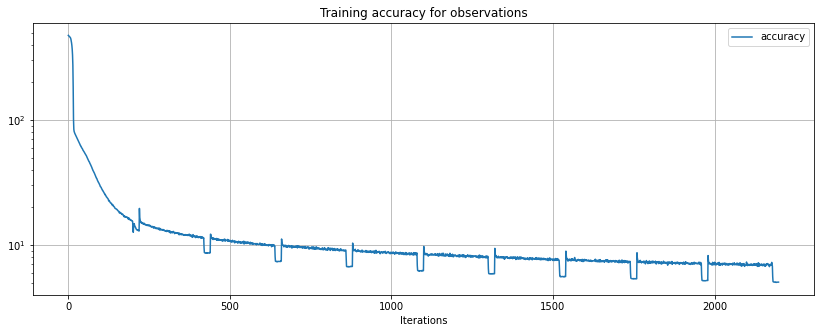

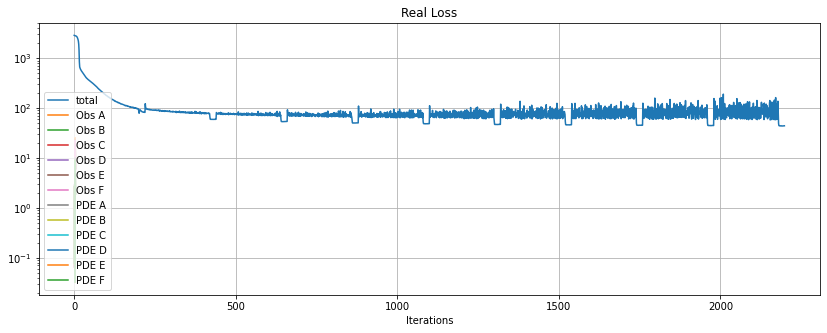

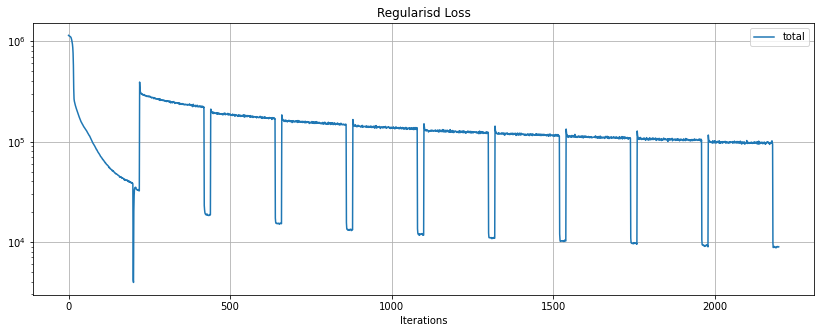

In [41]:
plot_result(merge_dict_multi_nodes(node_names,*results), node_names=node_names, start = 0)

In [48]:
results2 = model.train(epochs = 2000,
                      batch_size = 1024*8,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,#pde_mask,
                      #X_pde =  pde_X,
                      print_interval=10,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True,
                      regularise_int=1
                       )


Start of epoch 0
Training observations acc over epoch: 5.05753994
total loss: 44.14574581, total regularisd loss (sum of batches): 8901.28875732
obs A loss: 0.06662920, pde A loss: 0.07255610
obs B loss: 0.99862645, pde B loss: 2.57218375
obs C loss: 0.32699765, pde C loss: 0.03311585
obs D loss: 22.53767312, pde D loss: 9.10710713
obs E loss: 6.09712816, pde E loss: 1.92557055
obs F loss: 0.31818395, pde F loss: 0.08997423
lambda obs A: 0.01038399, lambda pde A: 0.00006114
lambda obs B: 0.35877883, lambda pde B: 0.07958323
lambda obs C: 0.42826805, lambda pde C: 0.00396368
lambda obs D: 6.53694630, lambda pde D: 0.94619095
lambda obs E: 3.34073067, lambda pde E: 0.20516226
lambda obs F: 0.08008962, lambda pde F: 0.00984081
b_A: 0.00000 b_B: 0.00000 b_C: 0.04985 b_D: 0.00000 
b_E: 0.07235 b_F: 0.00216 V_A: 0.02119 V_B: 0.68606 
V_C: 0.00000 V_D: 137.88179 V_E: 40.94138 V_F: 13.32589 
k_AA: 14.61433 k_BD: 5.02426 k_CE: 2.01401 k_DA: 8.59315 
k_EB: 26.79631 k_EE: 14.35501 k_FE: 2.12769 


Start of epoch 80
Training observations acc over epoch: 5.18155289
total loss: 45.55517259, total regularisd loss (sum of batches): 8881.73757935
obs A loss: 0.06715460, pde A loss: 0.00608347
obs B loss: 0.95273712, pde B loss: 2.59175018
obs C loss: 0.32867434, pde C loss: 0.03590692
obs D loss: 23.25876726, pde D loss: 9.76293342
obs E loss: 6.16643685, pde E loss: 1.97389836
obs F loss: 0.31554634, pde F loss: 0.09528354
lambda obs A: 0.01159674, lambda pde A: 0.00000093
lambda obs B: 0.36817992, lambda pde B: 0.07661856
lambda obs C: 0.43901563, lambda pde C: 0.00454989
lambda obs D: 6.34103775, lambda pde D: 0.96847385
lambda obs E: 3.48470306, lambda pde E: 0.20922679
lambda obs F: 0.08550760, lambda pde F: 0.01108922
b_A: 0.00802 b_B: 0.00000 b_C: 0.05044 b_D: 0.00000 
b_E: 0.05341 b_F: 0.00014 V_A: 0.01741 V_B: 0.65298 
V_C: 0.00000 V_D: 138.54250 V_E: 41.14120 V_F: 13.53876 
k_AA: 14.64577 k_BD: 4.92702 k_CE: 2.02267 k_DA: 8.49777 
k_EB: 26.55747 k_EE: 14.30975 k_FE: 2.37982


Start of epoch 160
Training observations acc over epoch: 5.24220753
total loss: 46.24549612, total regularisd loss (sum of batches): 8963.32780457
obs A loss: 0.06655039, pde A loss: 0.07523107
obs B loss: 0.94535005, pde B loss: 2.53751865
obs C loss: 0.33002720, pde C loss: 0.03761106
obs D loss: 23.56526479, pde D loss: 10.05428307
obs E loss: 6.22804888, pde E loss: 1.99007960
obs F loss: 0.31800888, pde F loss: 0.09752254
lambda obs A: 0.01262723, lambda pde A: 0.00006387
lambda obs B: 0.39828926, lambda pde B: 0.08233812
lambda obs C: 0.46702820, lambda pde C: 0.00483470
lambda obs D: 6.13804436, lambda pde D: 1.03055739
lambda obs E: 3.52921247, lambda pde E: 0.23556720
lambda obs F: 0.08997244, lambda pde F: 0.01146525
b_A: 0.00764 b_B: 0.00000 b_C: 0.05533 b_D: 0.00000 
b_E: 0.05680 b_F: 0.00000 V_A: 0.01740 V_B: 0.65669 
V_C: 0.00000 V_D: 139.39511 V_E: 41.35568 V_F: 13.61023 
k_AA: 14.64389 k_BD: 4.84198 k_CE: 2.01757 k_DA: 8.49777 
k_EB: 26.19481 k_EE: 14.19128 k_FE: 2.450


Start of epoch 240
Training observations acc over epoch: 5.18758011
total loss: 46.22577906, total regularisd loss (sum of batches): 8632.71810913
obs A loss: 0.06653519, pde A loss: 0.07798103
obs B loss: 0.95079497, pde B loss: 2.58520192
obs C loss: 0.33004002, pde C loss: 0.03785908
obs D loss: 23.27136162, pde D loss: 10.28324546
obs E loss: 6.19268751, pde E loss: 2.01655629
obs F loss: 0.31405667, pde F loss: 0.09945959
lambda obs A: 0.01337307, lambda pde A: 0.00007180
lambda obs B: 0.42562950, lambda pde B: 0.09680894
lambda obs C: 0.49317041, lambda pde C: 0.00536536
lambda obs D: 5.87606335, lambda pde D: 1.02324688
lambda obs E: 3.71154380, lambda pde E: 0.25534630
lambda obs F: 0.08807597, lambda pde F: 0.01130466
b_A: 0.00412 b_B: 0.00000 b_C: 0.05515 b_D: 0.00000 
b_E: 0.03858 b_F: 0.00016 V_A: 0.01772 V_B: 0.73225 
V_C: 0.00000 V_D: 140.19910 V_E: 41.54864 V_F: 13.69235 
k_AA: 14.57035 k_BD: 4.79234 k_CE: 2.00659 k_DA: 8.50139 
k_EB: 25.93917 k_EE: 14.12361 k_FE: 2.476


Start of epoch 320
Training observations acc over epoch: 5.07042599
total loss: 45.30255017, total regularisd loss (sum of batches): 8507.38519287
obs A loss: 0.06656079, pde A loss: 0.07854433
obs B loss: 0.93611132, pde B loss: 2.54412272
obs C loss: 0.32923277, pde C loss: 0.03921897
obs D loss: 22.64903170, pde D loss: 10.09408020
obs E loss: 6.13710648, pde E loss: 2.02587338
obs F loss: 0.30451246, pde F loss: 0.09815447
lambda obs A: 0.01238623, lambda pde A: 0.00006522
lambda obs B: 0.38426286, lambda pde B: 0.08260059
lambda obs C: 0.46603334, lambda pde C: 0.00505127
lambda obs D: 6.16607952, lambda pde D: 0.97393298
lambda obs E: 3.57313466, lambda pde E: 0.23856029
lambda obs F: 0.08740661, lambda pde F: 0.01048613
b_A: 0.00000 b_B: 0.00000 b_C: 0.05940 b_D: 0.00000 
b_E: 0.04944 b_F: 0.00000 V_A: 0.02374 V_B: 0.73710 
V_C: 0.00000 V_D: 140.98700 V_E: 41.77236 V_F: 13.76482 
k_AA: 14.56755 k_BD: 4.74746 k_CE: 2.01695 k_DA: 8.51480 
k_EB: 25.63841 k_EE: 14.07364 k_FE: 2.532


Start of epoch 400
Training observations acc over epoch: 5.18091488
total loss: 46.77098930, total regularisd loss (sum of batches): 8651.77017212
obs A loss: 0.06665645, pde A loss: 0.09748383
obs B loss: 0.93840666, pde B loss: 2.55320174
obs C loss: 0.33049392, pde C loss: 0.04037309
obs D loss: 23.24921763, pde D loss: 10.82174500
obs E loss: 6.18975396, pde E loss: 2.06778240
obs F loss: 0.31096670, pde F loss: 0.10490840
lambda obs A: 0.01415571, lambda pde A: 0.00008844
lambda obs B: 0.44064939, lambda pde B: 0.08707753
lambda obs C: 0.52269816, lambda pde C: 0.00552566
lambda obs D: 5.78407288, lambda pde D: 1.01934850
lambda obs E: 3.78445959, lambda pde E: 0.24237531
lambda obs F: 0.08827262, lambda pde F: 0.01127674
b_A: 0.00000 b_B: 0.00000 b_C: 0.05840 b_D: 0.00000 
b_E: 0.04183 b_F: 0.00000 V_A: 0.02161 V_B: 0.73373 
V_C: 0.00000 V_D: 141.75926 V_E: 41.98515 V_F: 13.83958 
k_AA: 14.57303 k_BD: 4.71968 k_CE: 2.01399 k_DA: 8.53734 
k_EB: 25.37766 k_EE: 14.03487 k_FE: 2.538


Start of epoch 480
Training observations acc over epoch: 4.90401125
total loss: 44.10709056, total regularisd loss (sum of batches): 8271.60057068
obs A loss: 0.06708801, pde A loss: 0.01123947
obs B loss: 0.93535579, pde B loss: 2.50880295
obs C loss: 0.32958023, pde C loss: 0.03859233
obs D loss: 21.71158127, pde D loss: 10.03078215
obs E loss: 6.08386081, pde E loss: 1.99621104
obs F loss: 0.29660374, pde F loss: 0.09739261
lambda obs A: 0.01272294, lambda pde A: 0.00000277
lambda obs B: 0.39185986, lambda pde B: 0.08697443
lambda obs C: 0.48748109, lambda pde C: 0.00549073
lambda obs D: 6.19654131, lambda pde D: 0.92665672
lambda obs E: 3.55849409, lambda pde E: 0.23738371
lambda obs F: 0.08525415, lambda pde F: 0.01113846
b_A: 0.02410 b_B: 0.00000 b_C: 0.05423 b_D: 0.00000 
b_E: 0.05401 b_F: 0.00088 V_A: 0.00000 V_B: 0.64230 
V_C: 0.00000 V_D: 142.37231 V_E: 42.11034 V_F: 13.90252 
k_AA: 14.65773 k_BD: 4.73500 k_CE: 2.00425 k_DA: 8.46378 
k_EB: 25.17160 k_EE: 14.16010 k_FE: 2.544


Start of epoch 560
Training observations acc over epoch: 5.03154945
total loss: 45.56156629, total regularisd loss (sum of batches): 8482.07211304
obs A loss: 0.06656173, pde A loss: 0.07670107
obs B loss: 0.92784560, pde B loss: 2.49920199
obs C loss: 0.32993662, pde C loss: 0.04063942
obs D loss: 22.39869528, pde D loss: 10.58775297
obs E loss: 6.16580693, pde E loss: 2.06479367
obs F loss: 0.30045424, pde F loss: 0.10317655
lambda obs A: 0.01378048, lambda pde A: 0.00006780
lambda obs B: 0.42003113, lambda pde B: 0.09910876
lambda obs C: 0.50312078, lambda pde C: 0.00557474
lambda obs D: 5.97905445, lambda pde D: 0.94627237
lambda obs E: 3.67725992, lambda pde E: 0.25683826
lambda obs F: 0.08815639, lambda pde F: 0.01073511
b_A: 0.02334 b_B: 0.00000 b_C: 0.05808 b_D: 0.00000 
b_E: 0.04796 b_F: 0.00000 V_A: 0.00001 V_B: 0.74089 
V_C: 0.00000 V_D: 143.14290 V_E: 42.36891 V_F: 13.98617 
k_AA: 14.56031 k_BD: 4.71039 k_CE: 2.01881 k_DA: 8.46378 
k_EB: 24.95584 k_EE: 14.08262 k_FE: 2.595


Start of epoch 640
Training observations acc over epoch: 4.92160892
total loss: 44.54081827, total regularisd loss (sum of batches): 8200.05226135
obs A loss: 0.06656423, pde A loss: 0.07741251
obs B loss: 0.92511787, pde B loss: 2.49884792
obs C loss: 0.32943995, pde C loss: 0.04154804
obs D loss: 21.82505862, pde D loss: 10.21460796
obs E loss: 6.08764289, pde E loss: 2.07904718
obs F loss: 0.29582717, pde F loss: 0.09970377
lambda obs A: 0.01327108, lambda pde A: 0.00006904
lambda obs B: 0.40484169, lambda pde B: 0.08192399
lambda obs C: 0.48865968, lambda pde C: 0.00535357
lambda obs D: 6.06527901, lambda pde D: 0.94103205
lambda obs E: 3.65977645, lambda pde E: 0.24063551
lambda obs F: 0.08862109, lambda pde F: 0.01053655
b_A: 0.01688 b_B: 0.00000 b_C: 0.06199 b_D: 0.00000 
b_E: 0.04714 b_F: 0.00000 V_A: 0.00102 V_B: 0.74790 
V_C: 0.00000 V_D: 143.89293 V_E: 42.59961 V_F: 14.07084 
k_AA: 14.55559 k_BD: 4.70002 k_CE: 2.02195 k_DA: 8.46378 
k_EB: 24.82293 k_EE: 14.02969 k_FE: 2.599


Start of epoch 720
Training observations acc over epoch: 4.90573835
total loss: 44.80235445, total regularisd loss (sum of batches): 8286.27984619
obs A loss: 0.06656033, pde A loss: 0.08006032
obs B loss: 0.92874845, pde B loss: 2.51280600
obs C loss: 0.33004857, pde C loss: 0.04160636
obs D loss: 21.70744114, pde D loss: 10.54843266
obs E loss: 6.10824848, pde E loss: 2.08220833
obs F loss: 0.29338027, pde F loss: 0.10281391
lambda obs A: 0.01326066, lambda pde A: 0.00006922
lambda obs B: 0.40450183, lambda pde B: 0.08841397
lambda obs C: 0.49898612, lambda pde C: 0.00552891
lambda obs D: 6.08339024, lambda pde D: 0.94256389
lambda obs E: 3.62532473, lambda pde E: 0.23873454
lambda obs F: 0.08897960, lambda pde F: 0.01024644
b_A: 0.00000 b_B: 0.00000 b_C: 0.05706 b_D: 0.00000 
b_E: 0.04187 b_F: 0.00028 V_A: 0.02035 V_B: 0.78759 
V_C: 0.00000 V_D: 144.61072 V_E: 42.79446 V_F: 14.13616 
k_AA: 14.51744 k_BD: 4.70078 k_CE: 2.01459 k_DA: 8.47143 
k_EB: 24.77865 k_EE: 14.01427 k_FE: 2.599


Start of epoch 800
Training observations acc over epoch: 4.91607904
total loss: 44.79741114, total regularisd loss (sum of batches): 8090.55215454
obs A loss: 0.06675063, pde A loss: 0.10044497
obs B loss: 0.92545364, pde B loss: 2.46842607
obs C loss: 0.32991068, pde C loss: 0.04164008
obs D loss: 21.76796857, pde D loss: 10.50889874
obs E loss: 6.11388250, pde E loss: 2.07958316
obs F loss: 0.29250786, pde F loss: 0.10194429
lambda obs A: 0.01443650, lambda pde A: 0.00010210
lambda obs B: 0.43979639, lambda pde B: 0.09532860
lambda obs C: 0.52574372, lambda pde C: 0.00568896
lambda obs D: 5.84495020, lambda pde D: 0.96994889
lambda obs E: 3.74414515, lambda pde E: 0.26010245
lambda obs F: 0.08887827, lambda pde F: 0.01087909
b_A: 0.00000 b_B: 0.00000 b_C: 0.06241 b_D: 0.00000 
b_E: 0.04271 b_F: 0.00007 V_A: 0.01909 V_B: 0.78127 
V_C: 0.00000 V_D: 145.32736 V_E: 42.97646 V_F: 14.21177 
k_AA: 14.52539 k_BD: 4.68845 k_CE: 2.01578 k_DA: 8.49532 
k_EB: 24.65156 k_EE: 14.02899 k_FE: 2.615


Start of epoch 880
Training observations acc over epoch: 4.83408070
total loss: 44.36942482, total regularisd loss (sum of batches): 8001.31402588
obs A loss: 0.06663374, pde A loss: 0.07228173
obs B loss: 0.91890655, pde B loss: 2.36774485
obs C loss: 0.32962042, pde C loss: 0.04162313
obs D loss: 21.32674631, pde D loss: 10.70293169
obs E loss: 6.07444259, pde E loss: 2.07690929
obs F loss: 0.28813699, pde F loss: 0.10344776
lambda obs A: 0.01406590, lambda pde A: 0.00005424
lambda obs B: 0.42412776, lambda pde B: 0.08225875
lambda obs C: 0.51114208, lambda pde C: 0.00560089
lambda obs D: 6.00960159, lambda pde D: 0.92570645
lambda obs E: 3.69269514, lambda pde E: 0.23464334
lambda obs F: 0.09007582, lambda pde F: 0.01002805
b_A: 0.00058 b_B: 0.00000 b_C: 0.05975 b_D: 0.00000 
b_E: 0.04334 b_F: 0.00000 V_A: 0.00008 V_B: 0.80927 
V_C: 0.00000 V_D: 146.01128 V_E: 43.14082 V_F: 14.28367 
k_AA: 14.49922 k_BD: 4.69283 k_CE: 2.01066 k_DA: 8.44389 
k_EB: 24.61267 k_EE: 14.06980 k_FE: 2.639


Start of epoch 960
Training observations acc over epoch: 4.84950495
total loss: 44.72769690, total regularisd loss (sum of batches): 7971.08250427
obs A loss: 0.06655991, pde A loss: 0.07814728
obs B loss: 0.91899403, pde B loss: 2.41942695
obs C loss: 0.32906832, pde C loss: 0.04245184
obs D loss: 21.41056217, pde D loss: 10.86300316
obs E loss: 6.08027576, pde E loss: 2.12360803
obs F loss: 0.29156646, pde F loss: 0.10403244
lambda obs A: 0.01419808, lambda pde A: 0.00007422
lambda obs B: 0.42765358, lambda pde B: 0.08897125
lambda obs C: 0.52749467, lambda pde C: 0.00572656
lambda obs D: 5.86809063, lambda pde D: 0.87442803
lambda obs E: 3.83855987, lambda pde E: 0.25504667
lambda obs F: 0.08919391, lambda pde F: 0.01056269
b_A: 0.00037 b_B: 0.00000 b_C: 0.06107 b_D: 0.00000 
b_E: 0.04567 b_F: 0.00000 V_A: 0.00231 V_B: 0.79543 
V_C: 0.00000 V_D: 146.73322 V_E: 43.31799 V_F: 14.35284 
k_AA: 14.51436 k_BD: 4.68749 k_CE: 2.00644 k_DA: 8.44389 
k_EB: 24.49936 k_EE: 14.06135 k_FE: 2.639


Start of epoch 1040
Training observations acc over epoch: 4.83740377
total loss: 44.55878508, total regularisd loss (sum of batches): 8158.84018707
obs A loss: 0.06657189, pde A loss: 0.07638625
obs B loss: 0.92193199, pde B loss: 2.36003963
obs C loss: 0.32976867, pde C loss: 0.04237177
obs D loss: 21.32823780, pde D loss: 10.81937622
obs E loss: 6.09091881, pde E loss: 2.13125679
obs F loss: 0.28699630, pde F loss: 0.10492857
lambda obs A: 0.01411102, lambda pde A: 0.00007041
lambda obs B: 0.42577475, lambda pde B: 0.08383959
lambda obs C: 0.51049936, lambda pde C: 0.00591814
lambda obs D: 5.98361111, lambda pde D: 0.97616720
lambda obs E: 3.64954948, lambda pde E: 0.25142649
lambda obs F: 0.08849394, lambda pde F: 0.01053899
b_A: 0.00000 b_B: 0.00000 b_C: 0.06306 b_D: 0.00000 
b_E: 0.04399 b_F: 0.00040 V_A: 0.01384 V_B: 0.78742 
V_C: 0.00000 V_D: 147.43279 V_E: 43.47638 V_F: 14.43740 
k_AA: 14.52392 k_BD: 4.67886 k_CE: 2.00825 k_DA: 8.44948 
k_EB: 24.40461 k_EE: 14.06817 k_FE: 2.64


Start of epoch 1120
Training observations acc over epoch: 4.74438858
total loss: 43.76761794, total regularisd loss (sum of batches): 7560.32872009
obs A loss: 0.06662973, pde A loss: 0.08210454
obs B loss: 0.92246354, pde B loss: 2.46144061
obs C loss: 0.32813436, pde C loss: 0.04216078
obs D loss: 20.83660929, pde D loss: 10.49392986
obs E loss: 6.02899859, pde E loss: 2.11950975
obs F loss: 0.28349480, pde F loss: 0.10214219
lambda obs A: 0.01441772, lambda pde A: 0.00007651
lambda obs B: 0.43528974, lambda pde B: 0.08843359
lambda obs C: 0.52520603, lambda pde C: 0.00592094
lambda obs D: 5.81936932, lambda pde D: 0.93396932
lambda obs E: 3.82474113, lambda pde E: 0.25331423
lambda obs F: 0.08851555, lambda pde F: 0.01074572
b_A: 0.00000 b_B: 0.00000 b_C: 0.06327 b_D: 0.00000 
b_E: 0.04448 b_F: 0.00000 V_A: 0.02334 V_B: 0.78958 
V_C: 0.00000 V_D: 148.11948 V_E: 43.62158 V_F: 14.50368 
k_AA: 14.52349 k_BD: 4.68243 k_CE: 2.00601 k_DA: 8.47062 
k_EB: 24.34150 k_EE: 14.09602 k_FE: 2.66


Start of epoch 1200
Training observations acc over epoch: 4.71777773
total loss: 43.70494968, total regularisd loss (sum of batches): 7856.30310822
obs A loss: 0.06719862, pde A loss: 0.10441573
obs B loss: 0.90600760, pde B loss: 2.33711481
obs C loss: 0.32936434, pde C loss: 0.04244425
obs D loss: 20.70918757, pde D loss: 10.66398784
obs E loss: 6.01584902, pde E loss: 2.14606067
obs F loss: 0.27906035, pde F loss: 0.10425913
lambda obs A: 0.01426335, lambda pde A: 0.00026982
lambda obs B: 0.41864645, lambda pde B: 0.08968283
lambda obs C: 0.47907203, lambda pde C: 0.00542529
lambda obs D: 5.89436769, lambda pde D: 0.93491900
lambda obs E: 3.82186890, lambda pde E: 0.24246198
lambda obs F: 0.08890665, lambda pde F: 0.01011613
b_A: 0.01345 b_B: 0.00000 b_C: 0.05996 b_D: 0.00000 
b_E: 0.05049 b_F: 0.00000 V_A: 0.01580 V_B: 0.80189 
V_C: 0.00000 V_D: 148.74771 V_E: 43.72606 V_F: 14.58507 
k_AA: 14.51008 k_BD: 4.70422 k_CE: 2.00950 k_DA: 8.38866 
k_EB: 24.32006 k_EE: 14.18945 k_FE: 2.68


Start of epoch 1280
Training observations acc over epoch: 4.80384779
total loss: 45.00680259, total regularisd loss (sum of batches): 7869.67866516
obs A loss: 0.06718854, pde A loss: 0.17682625
obs B loss: 0.90307528, pde B loss: 2.50298727
obs C loss: 0.32826430, pde C loss: 0.04363575
obs D loss: 21.19319239, pde D loss: 11.16070835
obs E loss: 6.04436957, pde E loss: 2.19110924
obs F loss: 0.28699297, pde F loss: 0.10845306
lambda obs A: 0.01527658, lambda pde A: 0.00030090
lambda obs B: 0.44791442, lambda pde B: 0.09079880
lambda obs C: 0.54857051, lambda pde C: 0.00568730
lambda obs D: 5.50183201, lambda pde D: 0.98477614
lambda obs E: 4.04435730, lambda pde E: 0.26189256
lambda obs F: 0.08778930, lambda pde F: 0.01080349
b_A: 0.00827 b_B: 0.00000 b_C: 0.06410 b_D: 0.00000 
b_E: 0.04888 b_F: 0.00000 V_A: 0.00925 V_B: 0.81002 
V_C: 0.00000 V_D: 149.45357 V_E: 43.87116 V_F: 14.64040 
k_AA: 14.50364 k_BD: 4.69816 k_CE: 2.00946 k_DA: 8.38862 
k_EB: 24.31979 k_EE: 14.17676 k_FE: 2.69


Start of epoch 1360
Training observations acc over epoch: 4.70325041
total loss: 44.00064451, total regularisd loss (sum of batches): 7616.62972260
obs A loss: 0.06657806, pde A loss: 0.07996040
obs B loss: 0.90187124, pde B loss: 2.41864103
obs C loss: 0.32791445, pde C loss: 0.04340124
obs D loss: 20.63792560, pde D loss: 10.95537465
obs E loss: 6.00532494, pde E loss: 2.17826461
obs F loss: 0.27989077, pde F loss: 0.10549766
lambda obs A: 0.01467985, lambda pde A: 0.00007351
lambda obs B: 0.43054304, lambda pde B: 0.08799921
lambda obs C: 0.53317130, lambda pde C: 0.00607950
lambda obs D: 5.72207451, lambda pde D: 0.90130401
lambda obs E: 3.93352795, lambda pde E: 0.27039039
lambda obs F: 0.08999799, lambda pde F: 0.01015898
b_A: 0.00348 b_B: 0.00000 b_C: 0.06270 b_D: 0.00000 
b_E: 0.04980 b_F: 0.00000 V_A: 0.01148 V_B: 0.75249 
V_C: 0.00000 V_D: 150.12012 V_E: 44.01366 V_F: 14.71728 
k_AA: 14.56128 k_BD: 4.69552 k_CE: 2.01266 k_DA: 8.39136 
k_EB: 24.29314 k_EE: 14.17475 k_FE: 2.70


Start of epoch 1440
Training observations acc over epoch: 4.61450005
total loss: 42.99039987, total regularisd loss (sum of batches): 7433.95555878
obs A loss: 0.06657043, pde A loss: 0.08376888
obs B loss: 0.89505481, pde B loss: 2.41587467
obs C loss: 0.32833260, pde C loss: 0.04333091
obs D loss: 20.15724564, pde D loss: 10.49315060
obs E loss: 5.96623801, pde E loss: 2.16472973
obs F loss: 0.27355750, pde F loss: 0.10254609
lambda obs A: 0.01444085, lambda pde A: 0.00007578
lambda obs B: 0.41970068, lambda pde B: 0.08605900
lambda obs C: 0.50709110, lambda pde C: 0.00566114
lambda obs D: 5.85918903, lambda pde D: 0.90534163
lambda obs E: 3.85461569, lambda pde E: 0.24766967
lambda obs F: 0.08998244, lambda pde F: 0.01017311
b_A: 0.00000 b_B: 0.00000 b_C: 0.06495 b_D: 0.00000 
b_E: 0.04991 b_F: 0.00000 V_A: 0.02323 V_B: 0.77397 
V_C: 0.00000 V_D: 150.79834 V_E: 44.15768 V_F: 14.78018 
k_AA: 14.54185 k_BD: 4.69417 k_CE: 2.01327 k_DA: 8.40606 
k_EB: 24.28923 k_EE: 14.16959 k_FE: 2.73


Start of epoch 1520
Training observations acc over epoch: 4.61353636
total loss: 42.92105410, total regularisd loss (sum of batches): 7746.55173492
obs A loss: 0.06735499, pde A loss: 0.00093889
obs B loss: 0.97807290, pde B loss: 2.29587498
obs C loss: 0.32889443, pde C loss: 0.04096478
obs D loss: 20.04421130, pde D loss: 10.61453213
obs E loss: 5.98941800, pde E loss: 2.18588300
obs F loss: 0.27327099, pde F loss: 0.10163749
lambda obs A: 0.01333866, lambda pde A: 0.00335090
lambda obs B: 0.44123521, lambda pde B: 0.08201035
lambda obs C: 0.48149115, lambda pde C: 0.00509165
lambda obs D: 5.93918228, lambda pde D: 0.92728019
lambda obs E: 3.78216815, lambda pde E: 0.22830212
lambda obs F: 0.08700064, lambda pde F: 0.00954779
b_A: 0.00992 b_B: 0.00000 b_C: 0.05602 b_D: 0.00000 
b_E: 0.02680 b_F: 0.00000 V_A: 0.00000 V_B: 0.77827 
V_C: 0.00000 V_D: 151.38071 V_E: 44.11845 V_F: 14.80093 
k_AA: 14.53894 k_BD: 4.75110 k_CE: 1.90515 k_DA: 8.32785 
k_EB: 24.27854 k_EE: 14.40361 k_FE: 2.52


Start of epoch 1600
Training observations acc over epoch: 4.61627579
total loss: 43.48824275, total regularisd loss (sum of batches): 7420.03452301
obs A loss: 0.06665433, pde A loss: 0.07747566
obs B loss: 0.88499673, pde B loss: 2.41534498
obs C loss: 0.32749437, pde C loss: 0.04324081
obs D loss: 20.16563980, pde D loss: 10.94253173
obs E loss: 5.98153773, pde E loss: 2.20599100
obs F loss: 0.27132832, pde F loss: 0.10600765
lambda obs A: 0.01530897, lambda pde A: 0.00006752
lambda obs B: 0.43594861, lambda pde B: 0.09312981
lambda obs C: 0.55483794, lambda pde C: 0.00597302
lambda obs D: 5.73254013, lambda pde D: 0.92142683
lambda obs E: 3.87786865, lambda pde E: 0.26205707
lambda obs F: 0.09028785, lambda pde F: 0.01055335
b_A: 0.00972 b_B: 0.00000 b_C: 0.06324 b_D: 0.00000 
b_E: 0.05466 b_F: 0.00000 V_A: 0.00013 V_B: 0.77145 
V_C: 0.00000 V_D: 152.04813 V_E: 44.37803 V_F: 14.92455 
k_AA: 14.54783 k_BD: 4.70860 k_CE: 2.01836 k_DA: 8.32785 
k_EB: 24.19280 k_EE: 14.25265 k_FE: 2.75


Start of epoch 1680
Training observations acc over epoch: 4.56665945
total loss: 43.05882788, total regularisd loss (sum of batches): 7384.21532440
obs A loss: 0.06658093, pde A loss: 0.07846437
obs B loss: 0.89403101, pde B loss: 2.43037123
obs C loss: 0.32705069, pde C loss: 0.04365726
obs D loss: 19.88898510, pde D loss: 10.80710255
obs E loss: 5.95351745, pde E loss: 2.19408551
obs F loss: 0.26979374, pde F loss: 0.10518819
lambda obs A: 0.01455980, lambda pde A: 0.00007270
lambda obs B: 0.42018384, lambda pde B: 0.09028564
lambda obs C: 0.52584827, lambda pde C: 0.00561594
lambda obs D: 5.77849245, lambda pde D: 0.93972504
lambda obs E: 3.88529897, lambda pde E: 0.23917127
lambda obs F: 0.09050276, lambda pde F: 0.01024313
b_A: 0.00825 b_B: 0.00000 b_C: 0.06767 b_D: 0.00000 
b_E: 0.05230 b_F: 0.00000 V_A: 0.00217 V_B: 0.78643 
V_C: 0.00000 V_D: 152.69075 V_E: 44.48179 V_F: 14.97942 
k_AA: 14.53472 k_BD: 4.70315 k_CE: 2.00720 k_DA: 8.32785 
k_EB: 24.18178 k_EE: 14.26236 k_FE: 2.75


Start of epoch 1760
Training observations acc over epoch: 4.54153585
total loss: 42.58372140, total regularisd loss (sum of batches): 7338.32433319
obs A loss: 0.06656898, pde A loss: 0.08322742
obs B loss: 0.88078545, pde B loss: 2.46171369
obs C loss: 0.32630049, pde C loss: 0.04321701
obs D loss: 19.77015939, pde D loss: 10.45702469
obs E loss: 5.93906106, pde E loss: 2.18657770
obs F loss: 0.26634083, pde F loss: 0.10274446
lambda obs A: 0.01448624, lambda pde A: 0.00007376
lambda obs B: 0.41109845, lambda pde B: 0.08446784
lambda obs C: 0.51862580, lambda pde C: 0.00602897
lambda obs D: 5.94857454, lambda pde D: 0.88321829
lambda obs E: 3.78007936, lambda pde E: 0.25436115
lambda obs F: 0.08921151, lambda pde F: 0.00977391
b_A: 0.00000 b_B: 0.00000 b_C: 0.06526 b_D: 0.00000 
b_E: 0.06021 b_F: 0.00000 V_A: 0.01511 V_B: 0.77566 
V_C: 0.00000 V_D: 153.33350 V_E: 44.59693 V_F: 15.04811 
k_AA: 14.54640 k_BD: 4.69815 k_CE: 2.01712 k_DA: 8.33317 
k_EB: 24.20961 k_EE: 14.27644 k_FE: 2.78


Start of epoch 1840
Training observations acc over epoch: 4.57725143
total loss: 43.59791279, total regularisd loss (sum of batches): 7241.59508514
obs A loss: 0.06664838, pde A loss: 0.09335165
obs B loss: 0.87839392, pde B loss: 2.48497496
obs C loss: 0.32616590, pde C loss: 0.04369982
obs D loss: 19.95688288, pde D loss: 11.17233741
obs E loss: 5.96467445, pde E loss: 2.23186084
obs F loss: 0.27074010, pde F loss: 0.10818262
lambda obs A: 0.01585798, lambda pde A: 0.00008759
lambda obs B: 0.45149708, lambda pde B: 0.08961678
lambda obs C: 0.56896406, lambda pde C: 0.00585714
lambda obs D: 5.57628441, lambda pde D: 0.84648526
lambda obs E: 4.09505081, lambda pde E: 0.25165570
lambda obs F: 0.08889148, lambda pde F: 0.00975190
b_A: 0.00000 b_B: 0.00004 b_C: 0.06619 b_D: 0.00000 
b_E: 0.06185 b_F: 0.00000 V_A: 0.02169 V_B: 0.71060 
V_C: 0.00000 V_D: 153.97083 V_E: 44.71112 V_F: 15.12086 
k_AA: 14.61111 k_BD: 4.68300 k_CE: 2.02079 k_DA: 8.35397 
k_EB: 24.21358 k_EE: 14.28528 k_FE: 2.77


Start of epoch 1920
Training observations acc over epoch: 4.44685602
total loss: 41.79165846, total regularisd loss (sum of batches): 7527.01868439
obs A loss: 0.06724371, pde A loss: 0.00245164
obs B loss: 0.91996487, pde B loss: 2.36782607
obs C loss: 0.32607773, pde C loss: 0.04189026
obs D loss: 19.17499189, pde D loss: 10.35224142
obs E loss: 5.92686205, pde E loss: 2.24392142
obs F loss: 0.26599711, pde F loss: 0.10219037
lambda obs A: 0.01333995, lambda pde A: 0.00000026
lambda obs B: 0.40414107, lambda pde B: 0.07205111
lambda obs C: 0.48247725, lambda pde C: 0.00441500
lambda obs D: 6.16215324, lambda pde D: 0.83314186
lambda obs E: 3.72800469, lambda pde E: 0.20683363
lambda obs F: 0.08406651, lambda pde F: 0.00937470
b_A: 0.00499 b_B: 0.00000 b_C: 0.06313 b_D: 0.00000 
b_E: 0.07742 b_F: 0.00000 V_A: 0.00509 V_B: 0.76783 
V_C: 0.00000 V_D: 154.40955 V_E: 44.65007 V_F: 15.16589 
k_AA: 14.55234 k_BD: 4.75789 k_CE: 1.94669 k_DA: 8.28316 
k_EB: 24.44327 k_EE: 14.52631 k_FE: 2.58

In [49]:
results3 = model.train(epochs = 2000,
                      batch_size = 1024*8,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,#pde_mask,
                      #X_pde =  pde_X,
                      print_interval=10,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=True,
                      regularise_int=1
                       )


Start of epoch 0
Training observations acc over epoch: 4.53980303
total loss: 43.11288941, total regularisd loss (sum of batches): 7406.87122345
obs A loss: 0.06664307, pde A loss: 0.07666818
obs B loss: 0.88050124, pde B loss: 2.45646141
obs C loss: 0.32578102, pde C loss: 0.04354174
obs D loss: 19.75842804, pde D loss: 10.94284618
obs E loss: 5.93757218, pde E loss: 2.24851925
obs F loss: 0.26989351, pde F loss: 0.10603334
lambda obs A: 0.01516153, lambda pde A: 0.00006274
lambda obs B: 0.43100965, lambda pde B: 0.09177962
lambda obs C: 0.52363253, lambda pde C: 0.00604913
lambda obs D: 5.77380562, lambda pde D: 0.88506556
lambda obs E: 3.91562033, lambda pde E: 0.25637504
lambda obs F: 0.09153822, lambda pde F: 0.00990062
b_A: 0.00490 b_B: 0.00000 b_C: 0.06655 b_D: 0.00000 
b_E: 0.06307 b_F: 0.00000 V_A: 0.00526 V_B: 0.68193 
V_C: 0.00000 V_D: 155.07890 V_E: 44.84490 V_F: 15.24090 
k_AA: 14.63567 k_BD: 4.71743 k_CE: 2.01835 k_DA: 8.28316 
k_EB: 24.40245 k_EE: 14.40895 k_FE: 2.77791


Start of epoch 80
Training observations acc over epoch: 4.52252054
total loss: 43.33824971, total regularisd loss (sum of batches): 7256.02021027
obs A loss: 0.06660505, pde A loss: 0.07739834
obs B loss: 0.87961324, pde B loss: 2.60807174
obs C loss: 0.32531762, pde C loss: 0.04445310
obs D loss: 19.66838206, pde D loss: 11.08226420
obs E loss: 5.92721513, pde E loss: 2.28324962
obs F loss: 0.26799038, pde F loss: 0.10768928
lambda obs A: 0.01551460, lambda pde A: 0.00007394
lambda obs B: 0.43969321, lambda pde B: 0.08932211
lambda obs C: 0.55877233, lambda pde C: 0.00568980
lambda obs D: 5.66446209, lambda pde D: 0.92030954
lambda obs E: 3.95006990, lambda pde E: 0.25355092
lambda obs F: 0.09184824, lambda pde F: 0.01069373
b_A: 0.00368 b_B: 0.00000 b_C: 0.06529 b_D: 0.00000 
b_E: 0.05876 b_F: 0.00000 V_A: 0.00757 V_B: 0.71385 
V_C: 0.00000 V_D: 155.70609 V_E: 44.94106 V_F: 15.29069 
k_AA: 14.60606 k_BD: 4.70828 k_CE: 2.02107 k_DA: 8.28606 
k_EB: 24.37925 k_EE: 14.38417 k_FE: 2.7934


Start of epoch 160
Training observations acc over epoch: 4.50802565
total loss: 43.28275475, total regularisd loss (sum of batches): 7285.10877228
obs A loss: 0.06661178, pde A loss: 0.07763070
obs B loss: 0.87244002, pde B loss: 2.42381605
obs C loss: 0.32530728, pde C loss: 0.04502415
obs D loss: 19.59738742, pde D loss: 11.25471928
obs E loss: 5.92044878, pde E loss: 2.32427338
obs F loss: 0.26596106, pde F loss: 0.10913460
lambda obs A: 0.01533072, lambda pde A: 0.00007402
lambda obs B: 0.43009779, lambda pde B: 0.07903133
lambda obs C: 0.54504663, lambda pde C: 0.00646842
lambda obs D: 5.79031372, lambda pde D: 0.88738686
lambda obs E: 3.86125469, lambda pde E: 0.28103343
lambda obs F: 0.09393549, lambda pde F: 0.01002641
b_A: 0.00000 b_B: 0.00013 b_C: 0.06777 b_D: 0.00000 
b_E: 0.06656 b_F: 0.00000 V_A: 0.01928 V_B: 0.70609 
V_C: 0.00000 V_D: 156.30124 V_E: 45.02420 V_F: 15.34315 
k_AA: 14.61533 k_BD: 4.71339 k_CE: 2.01685 k_DA: 8.29768 
k_EB: 24.36987 k_EE: 14.38682 k_FE: 2.803


Start of epoch 240
Training observations acc over epoch: 4.48120070
total loss: 42.62782687, total regularisd loss (sum of batches): 7289.87564850
obs A loss: 0.06666357, pde A loss: 0.09110831
obs B loss: 0.87701283, pde B loss: 2.48603524
obs C loss: 0.32489809, pde C loss: 0.04453633
obs D loss: 19.42386368, pde D loss: 10.73788982
obs E loss: 5.93031634, pde E loss: 2.27592052
obs F loss: 0.26445101, pde F loss: 0.10513091
lambda obs A: 0.01504161, lambda pde A: 0.00008082
lambda obs B: 0.42376888, lambda pde B: 0.08541238
lambda obs C: 0.53652114, lambda pde C: 0.00562864
lambda obs D: 5.76394749, lambda pde D: 0.88796687
lambda obs E: 3.95971084, lambda pde E: 0.22151412
lambda obs F: 0.09086101, lambda pde F: 0.00954586
b_A: 0.00000 b_B: 0.00000 b_C: 0.06712 b_D: 0.00000 
b_E: 0.06304 b_F: 0.00000 V_A: 0.02134 V_B: 0.70632 
V_C: 0.00000 V_D: 156.90967 V_E: 45.08390 V_F: 15.41751 
k_AA: 14.61693 k_BD: 4.70340 k_CE: 2.02457 k_DA: 8.31978 
k_EB: 24.38367 k_EE: 14.43698 k_FE: 2.824


Start of epoch 320
Training observations acc over epoch: 4.40658426
total loss: 42.11901101, total regularisd loss (sum of batches): 7087.70433044
obs A loss: 0.06711416, pde A loss: 0.01068745
obs B loss: 0.87280155, pde B loss: 2.49060390
obs C loss: 0.32406539, pde C loss: 0.04386077
obs D loss: 19.01682737, pde D loss: 10.73591921
obs E loss: 5.90109781, pde E loss: 2.29310414
obs F loss: 0.25760183, pde F loss: 0.10532718
lambda obs A: 0.01549983, lambda pde A: 0.00000267
lambda obs B: 0.43656570, lambda pde B: 0.09372585
lambda obs C: 0.56421030, lambda pde C: 0.00578795
lambda obs D: 5.66975927, lambda pde D: 0.83021241
lambda obs E: 4.05535889, lambda pde E: 0.22995506
lambda obs F: 0.08946373, lambda pde F: 0.00945754
b_A: 0.00231 b_B: 0.00000 b_C: 0.06944 b_D: 0.00000 
b_E: 0.08521 b_F: 0.00000 V_A: 0.02306 V_B: 0.65079 
V_C: 0.00000 V_D: 157.39578 V_E: 45.05674 V_F: 15.46393 
k_AA: 14.67090 k_BD: 4.73979 k_CE: 2.00551 k_DA: 8.35067 
k_EB: 24.50895 k_EE: 14.62569 k_FE: 2.783


Start of epoch 400
Training observations acc over epoch: 4.47689486
total loss: 43.37583083, total regularisd loss (sum of batches): 7200.12895966
obs A loss: 0.06662731, pde A loss: 0.07705951
obs B loss: 0.87108204, pde B loss: 2.60976261
obs C loss: 0.32468431, pde C loss: 0.04593734
obs D loss: 19.41000797, pde D loss: 11.29048026
obs E loss: 5.92649786, pde E loss: 2.38147820
obs F loss: 0.26246713, pde F loss: 0.10974642
lambda obs A: 0.01590069, lambda pde A: 0.00007158
lambda obs B: 0.44471955, lambda pde B: 0.09711801
lambda obs C: 0.56061518, lambda pde C: 0.00551029
lambda obs D: 5.62821960, lambda pde D: 0.88136476
lambda obs E: 4.04823351, lambda pde E: 0.21718481
lambda obs F: 0.09140934, lambda pde F: 0.00965148
b_A: 0.00202 b_B: 0.00000 b_C: 0.06804 b_D: 0.00000 
b_E: 0.06841 b_F: 0.00000 V_A: 0.02301 V_B: 0.65338 
V_C: 0.00000 V_D: 158.03502 V_E: 45.21323 V_F: 15.52019 
k_AA: 14.66995 k_BD: 4.70655 k_CE: 2.02774 k_DA: 8.35067 
k_EB: 24.53343 k_EE: 14.49288 k_FE: 2.821


Start of epoch 480
Training observations acc over epoch: 4.53655243
total loss: 43.98864761, total regularisd loss (sum of batches): 7249.97998047
obs A loss: 0.06660195, pde A loss: 0.08144678
obs B loss: 0.86608183, pde B loss: 2.53142457
obs C loss: 0.32556547, pde C loss: 0.04491833
obs D loss: 19.74117699, pde D loss: 11.67320943
obs E loss: 5.95149260, pde E loss: 2.32584964
obs F loss: 0.26839075, pde F loss: 0.11248900
lambda obs A: 0.01717405, lambda pde A: 0.00008433
lambda obs B: 0.47761956, lambda pde B: 0.09288548
lambda obs C: 0.60068011, lambda pde C: 0.00632351
lambda obs D: 5.32117558, lambda pde D: 0.92155302
lambda obs E: 4.21685219, lambda pde E: 0.24397723
lambda obs F: 0.09091731, lambda pde F: 0.01075716
b_A: 0.00000 b_B: 0.00000 b_C: 0.06895 b_D: 0.00000 
b_E: 0.07293 b_F: 0.00000 V_A: 0.02291 V_B: 0.70150 
V_C: 0.00000 V_D: 158.62637 V_E: 45.29510 V_F: 15.58131 
k_AA: 14.62365 k_BD: 4.69593 k_CE: 2.03136 k_DA: 8.35413 
k_EB: 24.58020 k_EE: 14.49289 k_FE: 2.849


Start of epoch 560
Training observations acc over epoch: 4.43371725
total loss: 43.08203697, total regularisd loss (sum of batches): 6998.49411774
obs A loss: 0.06664384, pde A loss: 0.07740725
obs B loss: 0.86407846, pde B loss: 2.54969881
obs C loss: 0.32484150, pde C loss: 0.04579577
obs D loss: 19.20248491, pde D loss: 11.35204985
obs E loss: 5.88036694, pde E loss: 2.34478462
obs F loss: 0.26388625, pde F loss: 0.10999887
lambda obs A: 0.01668971, lambda pde A: 0.00007842
lambda obs B: 0.46048066, lambda pde B: 0.09405106
lambda obs C: 0.56111252, lambda pde C: 0.00639792
lambda obs D: 5.45273924, lambda pde D: 0.87245393
lambda obs E: 4.16858101, lambda pde E: 0.26440203
lambda obs F: 0.09333141, lambda pde F: 0.00968205
b_A: 0.00000 b_B: 0.00000 b_C: 0.06859 b_D: 0.00000 
b_E: 0.07427 b_F: 0.00000 V_A: 0.02329 V_B: 0.67848 
V_C: 0.00000 V_D: 159.19626 V_E: 45.37109 V_F: 15.64310 
k_AA: 14.64878 k_BD: 4.69452 k_CE: 2.04008 k_DA: 8.36680 
k_EB: 24.59067 k_EE: 14.51066 k_FE: 2.848


Start of epoch 640
Training observations acc over epoch: 4.37448978
total loss: 42.22762841, total regularisd loss (sum of batches): 7348.69404602
obs A loss: 0.06733806, pde A loss: 0.01513813
obs B loss: 1.03794565, pde B loss: 2.61692750
obs C loss: 0.32730735, pde C loss: 0.04034478
obs D loss: 18.68623942, pde D loss: 10.89117035
obs E loss: 5.86703587, pde E loss: 2.31251579
obs F loss: 0.26107788, pde F loss: 0.10458755
lambda obs A: 0.01307248, lambda pde A: 0.00000868
lambda obs B: 0.46980169, lambda pde B: 0.07062183
lambda obs C: 0.47555232, lambda pde C: 0.00405487
lambda obs D: 5.98684835, lambda pde D: 0.91664505
lambda obs E: 3.78419256, lambda pde E: 0.18652269
lambda obs F: 0.08342754, lambda pde F: 0.00925234
b_A: 0.01291 b_B: 0.00000 b_C: 0.05206 b_D: 0.00000 
b_E: 0.03832 b_F: 0.00000 V_A: 0.00957 V_B: 0.71170 
V_C: 0.00000 V_D: 159.65550 V_E: 45.14985 V_F: 15.61695 
k_AA: 14.61696 k_BD: 4.75483 k_CE: 1.76178 k_DA: 8.34745 
k_EB: 24.66043 k_EE: 14.85613 k_FE: 2.406


Start of epoch 720
Training observations acc over epoch: 4.47743225
total loss: 43.72416472, total regularisd loss (sum of batches): 7340.58100891
obs A loss: 0.06679952, pde A loss: 0.07534482
obs B loss: 0.86059461, pde B loss: 2.49985372
obs C loss: 0.32593355, pde C loss: 0.04544625
obs D loss: 19.45020182, pde D loss: 11.79380082
obs E loss: 5.89689063, pde E loss: 2.33308915
obs F loss: 0.26417114, pde F loss: 0.11203878
lambda obs A: 0.01648694, lambda pde A: 0.00005833
lambda obs B: 0.45373741, lambda pde B: 0.09088706
lambda obs C: 0.54991150, lambda pde C: 0.00681198
lambda obs D: 5.54614639, lambda pde D: 0.85935402
lambda obs E: 4.08464861, lambda pde E: 0.28998733
lambda obs F: 0.09214594, lambda pde F: 0.00982447
b_A: 0.01282 b_B: 0.00000 b_C: 0.06749 b_D: 0.00000 
b_E: 0.07252 b_F: 0.00000 V_A: 0.00952 V_B: 0.65114 
V_C: 0.00000 V_D: 160.25676 V_E: 45.52266 V_F: 15.74066 
k_AA: 14.67034 k_BD: 4.71773 k_CE: 2.02662 k_DA: 8.34745 
k_EB: 24.67579 k_EE: 14.57311 k_FE: 2.855


Start of epoch 800
Training observations acc over epoch: 4.42363453
total loss: 43.01635933, total regularisd loss (sum of batches): 7118.75888824
obs A loss: 0.06662304, pde A loss: 0.07753803
obs B loss: 0.85751324, pde B loss: 2.56489084
obs C loss: 0.32379798, pde C loss: 0.04557174
obs D loss: 19.12086785, pde D loss: 11.33458746
obs E loss: 5.91273881, pde E loss: 2.34203934
obs F loss: 0.26026875, pde F loss: 0.10992195
lambda obs A: 0.01545564, lambda pde A: 0.00007240
lambda obs B: 0.42239067, lambda pde B: 0.09410313
lambda obs C: 0.55160177, lambda pde C: 0.00654874
lambda obs D: 5.62658405, lambda pde D: 0.88504195
lambda obs E: 4.03982830, lambda pde E: 0.25577539
lambda obs F: 0.09275845, lambda pde F: 0.00983907
b_A: 0.01124 b_B: 0.00000 b_C: 0.06897 b_D: 0.00000 
b_E: 0.07669 b_F: 0.00000 V_A: 0.00958 V_B: 0.71430 
V_C: 0.00000 V_D: 160.83232 V_E: 45.57790 V_F: 15.80707 
k_AA: 14.60849 k_BD: 4.70579 k_CE: 2.04546 k_DA: 8.34948 
k_EB: 24.68902 k_EE: 14.58529 k_FE: 2.873


Start of epoch 880
Training observations acc over epoch: 4.45623589
total loss: 44.05909187, total regularisd loss (sum of batches): 7287.86562347
obs A loss: 0.06662799, pde A loss: 0.07901231
obs B loss: 0.86560254, pde B loss: 2.60192668
obs C loss: 0.32407815, pde C loss: 0.04676239
obs D loss: 19.30776121, pde D loss: 12.05126397
obs E loss: 5.91077294, pde E loss: 2.42694783
obs F loss: 0.26257360, pde F loss: 0.11576252
lambda obs A: 0.01666593, lambda pde A: 0.00007794
lambda obs B: 0.46193680, lambda pde B: 0.09207980
lambda obs C: 0.57813632, lambda pde C: 0.00615259
lambda obs D: 5.51045227, lambda pde D: 0.86164439
lambda obs E: 4.11664867, lambda pde E: 0.25254053
lambda obs F: 0.09368122, lambda pde F: 0.00998420
b_A: 0.00236 b_B: 0.00000 b_C: 0.07235 b_D: 0.00000 
b_E: 0.06585 b_F: 0.00000 V_A: 0.01353 V_B: 0.71095 
V_C: 0.00000 V_D: 161.39899 V_E: 45.65483 V_F: 15.86630 
k_AA: 14.61340 k_BD: 4.69026 k_CE: 2.03728 k_DA: 8.35649 
k_EB: 24.66668 k_EE: 14.57353 k_FE: 2.879


Start of epoch 960
Training observations acc over epoch: 4.40399027
total loss: 43.45646125, total regularisd loss (sum of batches): 7159.14368439
obs A loss: 0.06666854, pde A loss: 0.07946576
obs B loss: 0.86377871, pde B loss: 2.73208231
obs C loss: 0.32392027, pde C loss: 0.04601023
obs D loss: 19.02739768, pde D loss: 11.67695968
obs E loss: 5.88387596, pde E loss: 2.38463131
obs F loss: 0.25829735, pde F loss: 0.11337373
lambda obs A: 0.01617811, lambda pde A: 0.00007618
lambda obs B: 0.44586870, lambda pde B: 0.09742948
lambda obs C: 0.55629855, lambda pde C: 0.00565611
lambda obs D: 5.57537651, lambda pde D: 0.88875449
lambda obs E: 4.05729198, lambda pde E: 0.25217903
lambda obs F: 0.09456444, lambda pde F: 0.01032592
b_A: 0.00000 b_B: 0.00000 b_C: 0.07244 b_D: 0.00000 
b_E: 0.07283 b_F: 0.00000 V_A: 0.02259 V_B: 0.70609 
V_C: 0.00000 V_D: 161.95245 V_E: 45.72123 V_F: 15.92467 
k_AA: 14.61951 k_BD: 4.68512 k_CE: 2.04099 k_DA: 8.37522 
k_EB: 24.66467 k_EE: 14.58142 k_FE: 2.877


Start of epoch 1040
Training observations acc over epoch: 4.28240013
total loss: 41.73477381, total regularisd loss (sum of batches): 7057.75541687
obs A loss: 0.06726533, pde A loss: 0.00276513
obs B loss: 0.95749060, pde B loss: 2.56079394
obs C loss: 0.32639377, pde C loss: 0.04288967
obs D loss: 18.26525779, pde D loss: 10.95499547
obs E loss: 5.82591853, pde E loss: 2.37290240
obs F loss: 0.25207287, pde F loss: 0.10602795
lambda obs A: 0.01388147, lambda pde A: 0.00000035
lambda obs B: 0.44126701, lambda pde B: 0.08382932
lambda obs C: 0.47336888, lambda pde C: 0.00466448
lambda obs D: 6.07695007, lambda pde D: 0.87192631
lambda obs E: 3.72676706, lambda pde E: 0.21248293
lambda obs F: 0.08547272, lambda pde F: 0.00938949
b_A: 0.00197 b_B: 0.00000 b_C: 0.06059 b_D: 0.00000 
b_E: 0.08512 b_F: 0.00000 V_A: 0.06551 V_B: 0.70418 
V_C: 0.00000 V_D: 162.39986 V_E: 45.58919 V_F: 15.91121 
k_AA: 14.62154 k_BD: 4.73207 k_CE: 1.87950 k_DA: 8.40443 
k_EB: 24.68720 k_EE: 14.89234 k_FE: 2.57


Start of epoch 1120
Training observations acc over epoch: 4.34609461
total loss: 43.01777744, total regularisd loss (sum of batches): 7114.72959137
obs A loss: 0.06666535, pde A loss: 0.07508467
obs B loss: 0.86183876, pde B loss: 2.62144750
obs C loss: 0.32321135, pde C loss: 0.04615336
obs D loss: 18.70975387, pde D loss: 11.64603898
obs E loss: 5.86133385, pde E loss: 2.43894626
obs F loss: 0.25376053, pde F loss: 0.11354259
lambda obs A: 0.01554297, lambda pde A: 0.00006312
lambda obs B: 0.42841464, lambda pde B: 0.08651744
lambda obs C: 0.55367863, lambda pde C: 0.00567799
lambda obs D: 5.67246389, lambda pde D: 0.84129608
lambda obs E: 4.06829834, lambda pde E: 0.22640795
lambda obs F: 0.09222233, lambda pde F: 0.00941741
b_A: 0.00135 b_B: 0.00000 b_C: 0.06925 b_D: 0.00000 
b_E: 0.07898 b_F: 0.00000 V_A: 0.06434 V_B: 0.71580 
V_C: 0.00000 V_D: 162.99170 V_E: 45.87349 V_F: 16.02273 
k_AA: 14.61226 k_BD: 4.69941 k_CE: 2.03637 k_DA: 8.40443 
k_EB: 24.68379 k_EE: 14.67648 k_FE: 2.88


Start of epoch 1200
Training observations acc over epoch: 4.32658529
total loss: 42.53353629, total regularisd loss (sum of batches): 6950.85352325
obs A loss: 0.06663808, pde A loss: 0.07863960
obs B loss: 0.86755658, pde B loss: 2.64057193
obs C loss: 0.32188668, pde C loss: 0.04586606
obs D loss: 18.60733803, pde D loss: 11.28682663
obs E loss: 5.84291019, pde E loss: 2.41210985
obs F loss: 0.25317892, pde F loss: 0.11001357
lambda obs A: 0.01590817, lambda pde A: 0.00007266
lambda obs B: 0.44266748, lambda pde B: 0.08763711
lambda obs C: 0.57234800, lambda pde C: 0.00597992
lambda obs D: 5.58130074, lambda pde D: 0.83714324
lambda obs E: 4.12393093, lambda pde E: 0.23235464
lambda obs F: 0.09104376, lambda pde F: 0.00961323
b_A: 0.00000 b_B: 0.00000 b_C: 0.06787 b_D: 0.00000 
b_E: 0.07863 b_F: 0.00000 V_A: 0.05267 V_B: 0.68868 
V_C: 0.00000 V_D: 163.54739 V_E: 45.95430 V_F: 16.07574 
k_AA: 14.64026 k_BD: 4.68815 k_CE: 2.03955 k_DA: 8.40631 
k_EB: 24.64706 k_EE: 14.66970 k_FE: 2.87


Start of epoch 1280
Training observations acc over epoch: 4.29521847
total loss: 42.40974385, total regularisd loss (sum of batches): 6842.76583099
obs A loss: 0.06662983, pde A loss: 0.08289154
obs B loss: 0.86180425, pde B loss: 2.57602357
obs C loss: 0.32173093, pde C loss: 0.04701999
obs D loss: 18.43730062, pde D loss: 11.37922553
obs E loss: 5.83219989, pde E loss: 2.44174681
obs F loss: 0.25164552, pde F loss: 0.11152539
lambda obs A: 0.01626595, lambda pde A: 0.00007532
lambda obs B: 0.44731393, lambda pde B: 0.08930108
lambda obs C: 0.59912455, lambda pde C: 0.00485246
lambda obs D: 5.60462046, lambda pde D: 0.83465493
lambda obs E: 4.08274412, lambda pde E: 0.21845919
lambda obs F: 0.09290984, lambda pde F: 0.00967785
b_A: 0.00000 b_B: 0.00000 b_C: 0.07335 b_D: 0.00000 
b_E: 0.07561 b_F: 0.00000 V_A: 0.02554 V_B: 0.71267 
V_C: 0.00000 V_D: 164.06949 V_E: 46.02618 V_F: 16.12762 
k_AA: 14.61821 k_BD: 4.68180 k_CE: 2.04601 k_DA: 8.41475 
k_EB: 24.64948 k_EE: 14.66712 k_FE: 2.89


Start of epoch 1360
Training observations acc over epoch: 4.30498266
total loss: 42.56517267, total regularisd loss (sum of batches): 6881.20877075
obs A loss: 0.06675017, pde A loss: 0.14101183
obs B loss: 0.85757980, pde B loss: 2.61986541
obs C loss: 0.32201713, pde C loss: 0.04621872
obs D loss: 18.49397789, pde D loss: 11.39853530
obs E loss: 5.83398229, pde E loss: 2.41742430
obs F loss: 0.25559032, pde F loss: 0.11221946
lambda obs A: 0.01607096, lambda pde A: 0.00012595
lambda obs B: 0.43782747, lambda pde B: 0.09150753
lambda obs C: 0.57316071, lambda pde C: 0.00634810
lambda obs D: 5.56923008, lambda pde D: 0.87843955
lambda obs E: 4.09734058, lambda pde E: 0.22698767
lambda obs F: 0.09303236, lambda pde F: 0.00992971
b_A: 0.00000 b_B: 0.00000 b_C: 0.07260 b_D: 0.00000 
b_E: 0.08482 b_F: 0.00000 V_A: 0.01936 V_B: 0.67276 
V_C: 0.00000 V_D: 164.58525 V_E: 46.10128 V_F: 16.18411 
k_AA: 14.65910 k_BD: 4.67307 k_CE: 2.05772 k_DA: 8.43024 
k_EB: 24.64166 k_EE: 14.68733 k_FE: 2.91


Start of epoch 1440
Training observations acc over epoch: 4.27410746
total loss: 41.93036553, total regularisd loss (sum of batches): 6712.84125519
obs A loss: 0.06680096, pde A loss: 0.06116462
obs B loss: 0.85900692, pde B loss: 2.55558831
obs C loss: 0.32175230, pde C loss: 0.04589318
obs D loss: 18.31922527, pde D loss: 11.09827069
obs E loss: 5.82655483, pde E loss: 2.41734062
obs F loss: 0.25130155, pde F loss: 0.10746687
lambda obs A: 0.01590167, lambda pde A: 0.00003694
lambda obs B: 0.43540376, lambda pde B: 0.08072050
lambda obs C: 0.54729712, lambda pde C: 0.00585612
lambda obs D: 5.51047039, lambda pde D: 0.86988795
lambda obs E: 4.18149185, lambda pde E: 0.25199804
lambda obs F: 0.09057982, lambda pde F: 0.01035580
b_A: 0.01411 b_B: 0.00000 b_C: 0.06983 b_D: 0.00000 
b_E: 0.09067 b_F: 0.00000 V_A: 0.00000 V_B: 0.59907 
V_C: 0.00000 V_D: 165.04504 V_E: 46.11610 V_F: 16.22821 
k_AA: 14.72999 k_BD: 4.70686 k_CE: 2.05015 k_DA: 8.42348 
k_EB: 24.70137 k_EE: 14.81148 k_FE: 2.88


Start of epoch 1520
Training observations acc over epoch: 4.38718128
total loss: 43.15187311, total regularisd loss (sum of batches): 6895.07068634
obs A loss: 0.06664150, pde A loss: 0.07714574
obs B loss: 0.85925962, pde B loss: 2.56292080
obs C loss: 0.32200627, pde C loss: 0.04655902
obs D loss: 18.92004274, pde D loss: 11.56488505
obs E loss: 5.89987090, pde E loss: 2.46426603
obs F loss: 0.25526617, pde F loss: 0.11300960
lambda obs A: 0.01803185, lambda pde A: 0.00007971
lambda obs B: 0.49139369, lambda pde B: 0.10480944
lambda obs C: 0.61223888, lambda pde C: 0.00710706
lambda obs D: 5.38263035, lambda pde D: 0.98359275
lambda obs E: 4.04784346, lambda pde E: 0.24850318
lambda obs F: 0.09287319, lambda pde F: 0.01089663
b_A: 0.01291 b_B: 0.00000 b_C: 0.07334 b_D: 0.00000 
b_E: 0.08037 b_F: 0.00000 V_A: 0.00069 V_B: 0.66862 
V_C: 0.00000 V_D: 165.58763 V_E: 46.22503 V_F: 16.28053 
k_AA: 14.66199 k_BD: 4.68887 k_CE: 2.06319 k_DA: 8.42348 
k_EB: 24.72502 k_EE: 14.74202 k_FE: 2.91


Start of epoch 1600
Training observations acc over epoch: 4.25297165
total loss: 42.56556743, total regularisd loss (sum of batches): 6780.63173676
obs A loss: 0.06664210, pde A loss: 0.07861468
obs B loss: 0.84228544, pde B loss: 2.58146619
obs C loss: 0.32054605, pde C loss: 0.04781335
obs D loss: 18.23595631, pde D loss: 11.73154241
obs E loss: 5.80064645, pde E loss: 2.49372829
obs F loss: 0.25175532, pde F loss: 0.11457057
lambda obs A: 0.01627820, lambda pde A: 0.00007240
lambda obs B: 0.43438539, lambda pde B: 0.09419488
lambda obs C: 0.58450276, lambda pde C: 0.00622677
lambda obs D: 5.54579163, lambda pde D: 0.82784528
lambda obs E: 4.13992691, lambda pde E: 0.24663308
lambda obs F: 0.09436262, lambda pde F: 0.00978041
b_A: 0.00527 b_B: 0.00000 b_C: 0.07374 b_D: 0.00000 
b_E: 0.09318 b_F: 0.00000 V_A: 0.00736 V_B: 0.70553 
V_C: 0.00000 V_D: 166.10352 V_E: 46.31132 V_F: 16.33149 
k_AA: 14.62682 k_BD: 4.68154 k_CE: 2.07860 k_DA: 8.42464 
k_EB: 24.73231 k_EE: 14.72601 k_FE: 2.94


Start of epoch 1680
Training observations acc over epoch: 4.31613779
total loss: 43.17902017, total regularisd loss (sum of batches): 6914.25232697
obs A loss: 0.06671390, pde A loss: 0.07504749
obs B loss: 0.85319628, pde B loss: 2.54446475
obs C loss: 0.32073744, pde C loss: 0.04733181
obs D loss: 18.56999470, pde D loss: 12.04870874
obs E loss: 5.83148785, pde E loss: 2.44995267
obs F loss: 0.25469429, pde F loss: 0.11668990
lambda obs A: 0.01666910, lambda pde A: 0.00007277
lambda obs B: 0.45197132, lambda pde B: 0.09225838
lambda obs C: 0.57599151, lambda pde C: 0.00597427
lambda obs D: 5.49089813, lambda pde D: 0.83583546
lambda obs E: 4.18376827, lambda pde E: 0.24391228
lambda obs F: 0.09277830, lambda pde F: 0.00986978
b_A: 0.00000 b_B: 0.00000 b_C: 0.07247 b_D: 0.00000 
b_E: 0.08369 b_F: 0.00000 V_A: 0.02257 V_B: 0.65404 
V_C: 0.00000 V_D: 166.60446 V_E: 46.37669 V_F: 16.38590 
k_AA: 14.67820 k_BD: 4.67716 k_CE: 2.06418 k_DA: 8.43890 
k_EB: 24.70462 k_EE: 14.72424 k_FE: 2.93


Start of epoch 1760
Training observations acc over epoch: 4.17868328
total loss: 41.50515914, total regularisd loss (sum of batches): 6754.23833466
obs A loss: 0.06713549, pde A loss: 0.01046289
obs B loss: 0.85392516, pde B loss: 2.49807044
obs C loss: 0.32184588, pde C loss: 0.04626423
obs D loss: 17.78874968, pde D loss: 11.34324427
obs E loss: 5.79632633, pde E loss: 2.42517497
obs F loss: 0.24411954, pde F loss: 0.10984065
lambda obs A: 0.01612395, lambda pde A: 0.00000250
lambda obs B: 0.43684322, lambda pde B: 0.08644728
lambda obs C: 0.56580091, lambda pde C: 0.00582311
lambda obs D: 5.62613010, lambda pde D: 0.77710342
lambda obs E: 4.18329620, lambda pde E: 0.20155287
lambda obs F: 0.09154906, lambda pde F: 0.00932645
b_A: 0.01702 b_B: 0.00000 b_C: 0.07097 b_D: 0.00000 
b_E: 0.10164 b_F: 0.00000 V_A: 0.00000 V_B: 0.72978 
V_C: 0.00000 V_D: 167.02382 V_E: 46.37972 V_F: 16.42498 
k_AA: 14.60315 k_BD: 4.72693 k_CE: 2.03364 k_DA: 8.41805 
k_EB: 24.74914 k_EE: 14.86799 k_FE: 2.88


Start of epoch 1840
Training observations acc over epoch: 4.27058744
total loss: 42.70790714, total regularisd loss (sum of batches): 6857.78285980
obs A loss: 0.06665417, pde A loss: 0.07901249
obs B loss: 0.85752298, pde B loss: 2.67438084
obs C loss: 0.32154188, pde C loss: 0.04692899
obs D loss: 18.29115848, pde D loss: 11.71015003
obs E loss: 5.83575370, pde E loss: 2.45923657
obs F loss: 0.25089372, pde F loss: 0.11467337
lambda obs A: 0.01672469, lambda pde A: 0.00006939
lambda obs B: 0.45603341, lambda pde B: 0.09105681
lambda obs C: 0.58989304, lambda pde C: 0.00588299
lambda obs D: 5.42345953, lambda pde D: 0.82191980
lambda obs E: 4.24836159, lambda pde E: 0.24464008
lambda obs F: 0.09280089, lambda pde F: 0.00915759
b_A: 0.01643 b_B: 0.00000 b_C: 0.07113 b_D: 0.00000 
b_E: 0.08600 b_F: 0.00000 V_A: 0.00018 V_B: 0.73252 
V_C: 0.00000 V_D: 167.57880 V_E: 46.55828 V_F: 16.48458 
k_AA: 14.60234 k_BD: 4.69203 k_CE: 2.06156 k_DA: 8.41805 
k_EB: 24.73724 k_EE: 14.71373 k_FE: 2.90


Start of epoch 1920
Training observations acc over epoch: 4.19746399
total loss: 41.76562762, total regularisd loss (sum of batches): 6581.82305145
obs A loss: 0.06665673, pde A loss: 0.07817576
obs B loss: 0.84480653, pde B loss: 2.60417209
obs C loss: 0.32159370, pde C loss: 0.04798029
obs D loss: 17.92409335, pde D loss: 11.26962841
obs E loss: 5.77643374, pde E loss: 2.46863911
obs F loss: 0.25120105, pde F loss: 0.11224707
lambda obs A: 0.01617484, lambda pde A: 0.00007162
lambda obs B: 0.43295044, lambda pde B: 0.08906861
lambda obs C: 0.54678655, lambda pde C: 0.00560206
lambda obs D: 5.60906219, lambda pde D: 0.86272836
lambda obs E: 4.11262608, lambda pde E: 0.21931651
lambda obs F: 0.09577686, lambda pde F: 0.00983628
b_A: 0.01129 b_B: 0.00000 b_C: 0.07644 b_D: 0.00000 
b_E: 0.09135 b_F: 0.00008 V_A: 0.00265 V_B: 0.74830 
V_C: 0.00000 V_D: 168.05098 V_E: 46.64780 V_F: 16.51721 
k_AA: 14.58840 k_BD: 4.69645 k_CE: 2.07210 k_DA: 8.41805 
k_EB: 24.74759 k_EE: 14.71273 k_FE: 2.93

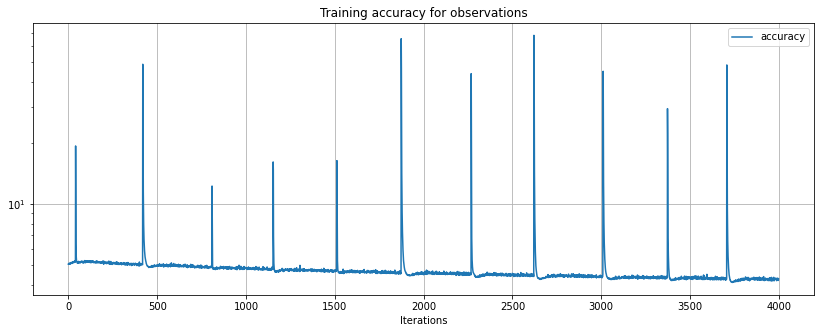

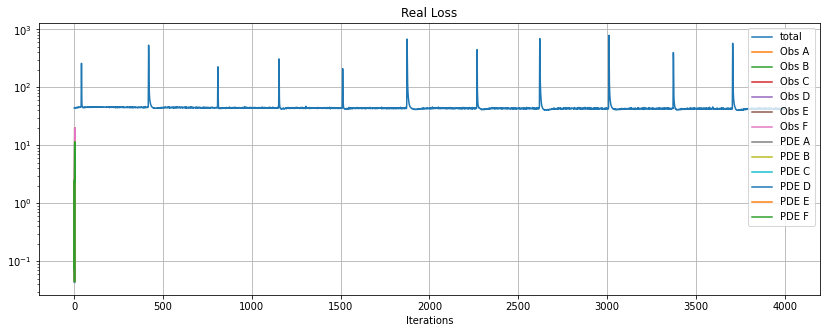

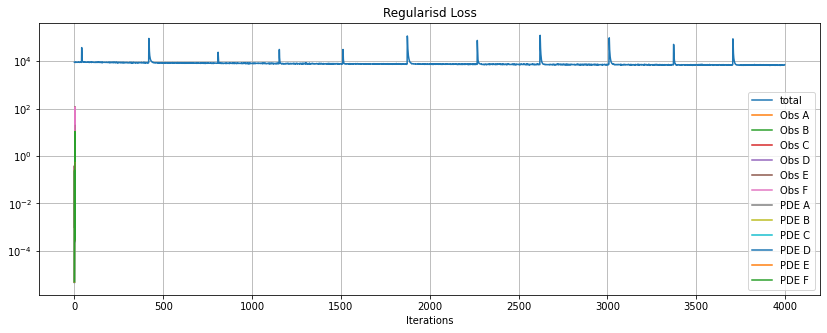

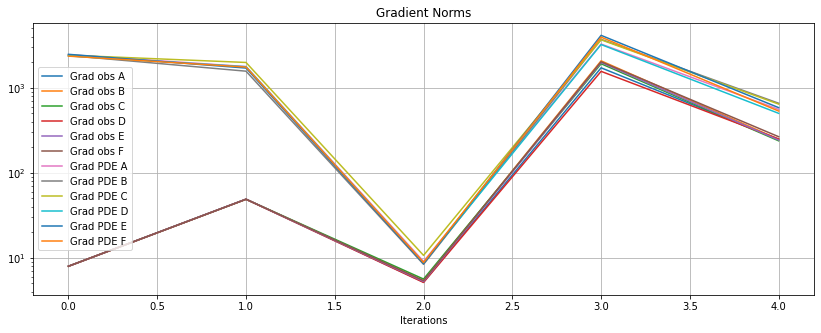

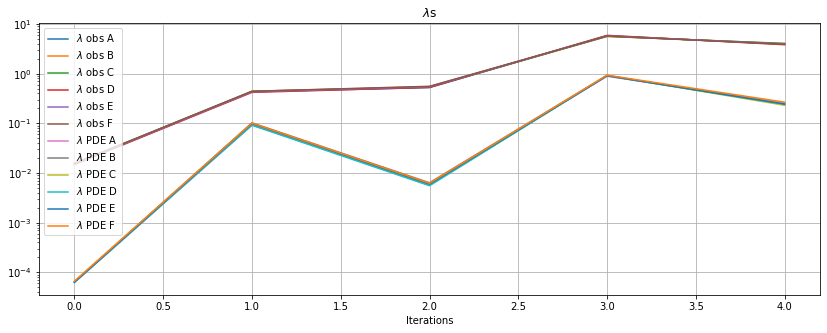

In [50]:
plot_result(merge_dict_multi_nodes(node_names,results2, results3), node_names=node_names, start = 0)

In [58]:
results5 = model.train(epochs = 10000,
                      batch_size = 1024,
                      X = obs_X,
                      Y = obs_Y,
                      domain_mask = obs_mask,#pde_mask,
                      #X_pde =  pde_X,
                      print_interval=100,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = False,
                      sample_gradients = False,
                      regularise=False
                       )


Start of epoch 0
Training observations acc over epoch: 10.36434746
total loss: 258.62836497, total regularisd loss (sum of batches): 195509.34586334
obs A loss: 0.10016859, pde A loss: 122.32842078
obs B loss: 1.40602996, pde B loss: 5.06929025
obs C loss: 0.53540121, pde C loss: 0.08133437
obs D loss: 76.85558739, pde D loss: 33.29154511
obs E loss: 13.01313318, pde E loss: 4.76745463
obs F loss: 0.87886175, pde F loss: 0.30113593
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.01063 b_B: 0.00000 b_C: 0.06088 b_D: 0.00000 
b_E: 0.00591 b_F: 0.00333 V_A: 0.00325 V_B: 0.87069 
V_C: 0.00000 V_D: 168.53416 V_E: 46.56484 V_F: 16.54522 
k_AA: 14.46555 k_BD: 4.71711 k_CE: 2.02529 k_DA: 8.42983 
k_EB: 24.85041 k_EE: 14.95239 k_FE: 


Start of epoch 800
Training observations acc over epoch: 5.76365185
total loss: 93.30008056, total regularisd loss (sum of batches): 72404.31085968
obs A loss: 0.06714331, pde A loss: 37.11951019
obs B loss: 0.88448790, pde B loss: 3.54394323
obs C loss: 0.32609900, pde C loss: 0.04373171
obs D loss: 26.63122350, pde D loss: 15.26368444
obs E loss: 6.30672973, pde E loss: 2.58842450
obs F loss: 0.36624305, pde F loss: 0.15886022
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.00611 b_B: 0.00000 b_C: 0.06204 b_D: 0.00011 
b_E: 0.05793 b_F: 0.00598 V_A: 0.01190 V_B: 0.95306 
V_C: 0.00000 V_D: 181.97375 V_E: 46.53606 V_F: 17.74511 
k_AA: 14.44898 k_BD: 5.15119 k_CE: 2.10083 k_DA: 8.94941 
k_EB: 24.23516 k_EE: 14.51776 k_FE: 2.6


Start of epoch 1600
Training observations acc over epoch: 5.56262159
total loss: 76.24714808, total regularisd loss (sum of batches): 70008.85025024
obs A loss: 0.06711170, pde A loss: 20.80405254
obs B loss: 0.93438530, pde B loss: 3.48056125
obs C loss: 0.32701436, pde C loss: 0.04567260
obs D loss: 25.51571431, pde D loss: 15.60266006
obs E loss: 6.17777562, pde E loss: 2.77625260
obs F loss: 0.35372497, pde F loss: 0.16222313
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.01134 b_B: 0.00006 b_C: 0.06267 b_D: 0.00003 
b_E: 0.05153 b_F: 0.00097 V_A: 0.01383 V_B: 0.85306 
V_C: 0.00000 V_D: 193.72617 V_E: 47.52379 V_F: 18.88233 
k_AA: 14.62415 k_BD: 5.14043 k_CE: 2.07532 k_DA: 9.28081 
k_EB: 24.10896 k_EE: 14.63864 k_FE: 2.


Start of epoch 2400
Training observations acc over epoch: 5.20551252
total loss: 90.43364779, total regularisd loss (sum of batches): 65529.19575500
obs A loss: 0.06721758, pde A loss: 37.36442200
obs B loss: 0.97255471, pde B loss: 3.40304974
obs C loss: 0.32641528, pde C loss: 0.04635760
obs D loss: 23.56000097, pde D loss: 15.42141846
obs E loss: 5.97215182, pde E loss: 2.80200014
obs F loss: 0.33473521, pde F loss: 0.16332400
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.01335 b_B: 0.00014 b_C: 0.06237 b_D: 0.00015 
b_E: 0.04555 b_F: 0.00450 V_A: 0.00358 V_B: 0.78987 
V_C: 0.00000 V_D: 204.25801 V_E: 48.87882 V_F: 19.85565 
k_AA: 14.75052 k_BD: 5.11085 k_CE: 2.03471 k_DA: 9.47761 
k_EB: 23.87317 k_EE: 14.84785 k_FE: 2.


Start of epoch 3200
Training observations acc over epoch: 5.16543961
total loss: 163.11937667, total regularisd loss (sum of batches): 65076.53166962
obs A loss: 0.06712328, pde A loss: 109.56949472
obs B loss: 1.01121177, pde B loss: 3.73304312
obs C loss: 0.32700049, pde C loss: 0.04786573
obs D loss: 23.29299934, pde D loss: 15.72907502
obs E loss: 5.95480684, pde E loss: 2.88066226
obs F loss: 0.33948003, pde F loss: 0.16661489
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.00784 b_B: 0.00000 b_C: 0.05762 b_D: 0.00000 
b_E: 0.04803 b_F: 0.00448 V_A: 0.01088 V_B: 0.63323 
V_C: 0.00000 V_D: 213.53204 V_E: 50.56119 V_F: 20.77266 
k_AA: 14.97122 k_BD: 5.06573 k_CE: 2.00589 k_DA: 9.51056 
k_EB: 23.78678 k_EE: 15.06540 k_FE: 


Start of epoch 4000
Training observations acc over epoch: 4.99003220
total loss: 268.10015135, total regularisd loss (sum of batches): 62992.77163696
obs A loss: 0.06812966, pde A loss: 215.03556563
obs B loss: 1.08382846, pde B loss: 3.56504622
obs C loss: 0.32809249, pde C loss: 0.04880137
obs D loss: 22.22872391, pde D loss: 16.33612811
obs E loss: 5.89727352, pde E loss: 3.00070752
obs F loss: 0.33414118, pde F loss: 0.17371311
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.00851 b_B: 0.00086 b_C: 0.05594 b_D: 0.00000 
b_E: 0.03339 b_F: 0.00905 V_A: 0.04779 V_B: 0.43949 
V_C: 0.00000 V_D: 222.12268 V_E: 52.13515 V_F: 21.62398 
k_AA: 15.27277 k_BD: 5.01777 k_CE: 1.90872 k_DA: 9.54994 
k_EB: 23.79270 k_EE: 15.20922 k_FE: 


Start of epoch 4800
Training observations acc over epoch: 4.68225336
total loss: 128.37088144, total regularisd loss (sum of batches): 58790.75043106
obs A loss: 0.06742878, pde A loss: 78.32306386
obs B loss: 1.10958073, pde B loss: 3.56989481
obs C loss: 0.32444363, pde C loss: 0.04717834
obs D loss: 20.57678922, pde D loss: 15.11582465
obs E loss: 5.69960751, pde E loss: 3.05747474
obs F loss: 0.31567348, pde F loss: 0.16392220
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.00639 b_B: 0.00000 b_C: 0.05448 b_D: 0.00000 
b_E: 0.02967 b_F: 0.00776 V_A: 0.00624 V_B: 0.42759 
V_C: 0.00000 V_D: 229.92278 V_E: 53.56272 V_F: 22.35339 
k_AA: 15.44610 k_BD: 4.99780 k_CE: 1.90463 k_DA: 9.50518 
k_EB: 24.06971 k_EE: 15.24576 k_FE: 2


Start of epoch 5600
Training observations acc over epoch: 5.09373665
total loss: 122.30244943, total regularisd loss (sum of batches): 64904.16999817
obs A loss: 0.06734095, pde A loss: 65.70250531
obs B loss: 1.13874141, pde B loss: 4.11204260
obs C loss: 0.32653616, pde C loss: 0.04891061
obs D loss: 22.72131592, pde D loss: 18.46610798
obs E loss: 5.96157328, pde E loss: 3.22240450
obs F loss: 0.34688636, pde F loss: 0.18808452
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.00000 b_B: 0.00000 b_C: 0.05811 b_D: 0.00000 
b_E: 0.03120 b_F: 0.00131 V_A: 0.03983 V_B: 0.38419 
V_C: 0.00000 V_D: 237.14957 V_E: 54.50862 V_F: 23.01418 
k_AA: 15.64945 k_BD: 4.97443 k_CE: 1.88745 k_DA: 9.48580 
k_EB: 24.05773 k_EE: 15.30228 k_FE: 2


Start of epoch 6400
Training observations acc over epoch: 4.73198748
total loss: 186.58366624, total regularisd loss (sum of batches): 60044.57853699
obs A loss: 0.06748421, pde A loss: 133.41296833
obs B loss: 1.19639669, pde B loss: 3.67149177
obs C loss: 0.32386041, pde C loss: 0.04787289
obs D loss: 20.77735011, pde D loss: 17.53368586
obs E loss: 5.69288825, pde E loss: 3.33954280
obs F loss: 0.33393758, pde F loss: 0.18618698
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.01676 b_B: 0.00258 b_C: 0.05218 b_D: 0.00000 
b_E: 0.00259 b_F: 0.00476 V_A: 0.02013 V_B: 0.26033 
V_C: 0.00000 V_D: 243.85684 V_E: 55.26580 V_F: 23.70572 
k_AA: 15.99661 k_BD: 4.96649 k_CE: 1.85338 k_DA: 9.44026 
k_EB: 24.19413 k_EE: 15.35218 k_FE: 


Start of epoch 7200
Training observations acc over epoch: 4.75370264
total loss: 673.70905542, total regularisd loss (sum of batches): 60223.18471527
obs A loss: 0.06849430, pde A loss: 620.59961406
obs B loss: 1.22266945, pde B loss: 3.74730058
obs C loss: 0.32449368, pde C loss: 0.04899158
obs D loss: 20.85406488, pde D loss: 17.31302673
obs E loss: 5.71660460, pde E loss: 3.29740102
obs F loss: 0.33588437, pde F loss: 0.18050849
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.04168 b_B: 0.00002 b_C: 0.04675 b_D: 0.00000 
b_E: 0.00366 b_F: 0.00896 V_A: 0.05723 V_B: 0.12420 
V_C: 0.00000 V_D: 250.31296 V_E: 56.30447 V_F: 24.26501 
k_AA: 16.42764 k_BD: 4.90613 k_CE: 1.85357 k_DA: 9.21469 
k_EB: 23.87734 k_EE: 15.39796 k_FE: 


Start of epoch 8000
Training observations acc over epoch: 4.53111267
total loss: 242.33964166, total regularisd loss (sum of batches): 57155.85373688
obs A loss: 0.06760822, pde A loss: 191.36725220
obs B loss: 1.27929815, pde B loss: 3.44714521
obs C loss: 0.32224611, pde C loss: 0.04892864
obs D loss: 19.59333822, pde D loss: 16.81723041
obs E loss: 5.58117399, pde E loss: 3.29395640
obs F loss: 0.34300659, pde F loss: 0.17845852
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.00068 b_B: 0.00037 b_C: 0.04622 b_D: 0.00000 
b_E: 0.00454 b_F: 0.00159 V_A: 0.00135 V_B: 0.01389 
V_C: 0.00000 V_D: 256.67294 V_E: 57.36841 V_F: 24.87450 
k_AA: 18.74018 k_BD: 4.85408 k_CE: 1.82790 k_DA: 8.90255 
k_EB: 23.62022 k_EE: 15.55308 k_FE: 


Start of epoch 8800
Training observations acc over epoch: 4.55524778
total loss: 433.34360571, total regularisd loss (sum of batches): 57626.89547729
obs A loss: 0.06741438, pde A loss: 381.43294365
obs B loss: 1.32905857, pde B loss: 3.75509498
obs C loss: 0.32182762, pde C loss: 0.04717824
obs D loss: 19.69494468, pde D loss: 17.32377010
obs E loss: 5.57671531, pde E loss: 3.27129740
obs F loss: 0.34154194, pde F loss: 0.18181908
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.01257 b_B: 0.00000 b_C: 0.04454 b_D: 0.00000 
b_E: 0.00000 b_F: 0.00811 V_A: 0.01269 V_B: 0.00074 
V_C: 0.00000 V_D: 262.73126 V_E: 58.37427 V_F: 25.36967 
k_AA: 23.02107 k_BD: 4.80834 k_CE: 1.82088 k_DA: 8.80094 
k_EB: 23.70720 k_EE: 15.76121 k_FE: 


Start of epoch 9600
Training observations acc over epoch: 4.37521315
total loss: 246.95733634, total regularisd loss (sum of batches): 54843.72319794
obs A loss: 0.06762652, pde A loss: 197.54105313
obs B loss: 1.36437228, pde B loss: 3.41612270
obs C loss: 0.32236167, pde C loss: 0.04719422
obs D loss: 18.69444160, pde D loss: 16.15003645
obs E loss: 5.46217306, pde E loss: 3.38250661
obs F loss: 0.34030102, pde F loss: 0.16914755
lambda obs A: 0.01788347, lambda pde A: 0.00008249
lambda obs B: 0.48173818, lambda pde B: 0.09273930
lambda obs C: 0.59627175, lambda pde C: 0.00722735
lambda obs D: 5.28943920, lambda pde D: 0.88715279
lambda obs E: 4.23254204, lambda pde E: 0.29171944
lambda obs F: 0.09277445, lambda pde F: 0.01042946
b_A: 0.05300 b_B: 0.00000 b_C: 0.04009 b_D: 0.00000 
b_E: 0.00000 b_F: 0.01624 V_A: 0.03930 V_B: 0.00000 
V_C: 0.00000 V_D: 268.78162 V_E: 59.62051 V_F: 25.90135 
k_AA: 27.03562 k_BD: 4.74692 k_CE: 1.77689 k_DA: 8.69944 
k_EB: 23.50756 k_EE: 15.88509 k_FE: 

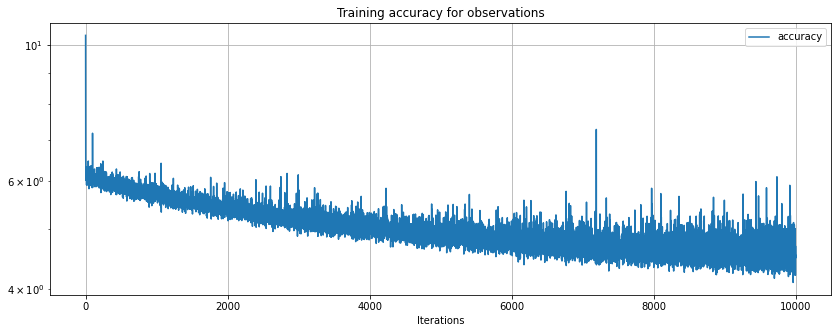

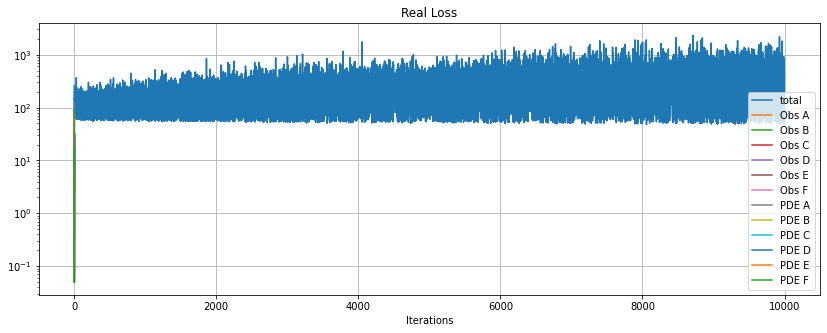

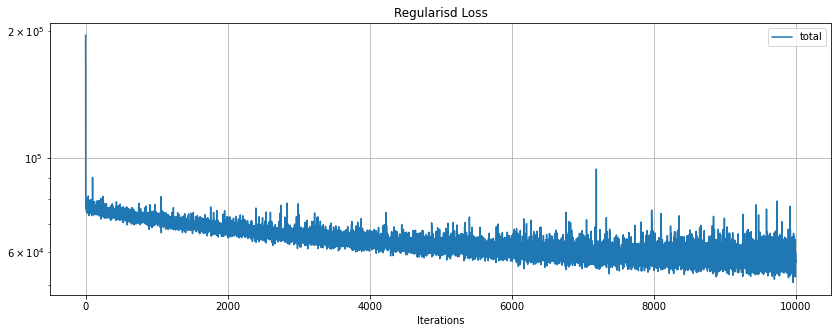

In [61]:
plot_result(merge_dict_multi_nodes(node_names,results5), node_names=node_names, start = 0)

In [62]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)

T_test_index = 0#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N x 1
YY_test = Y_test.flatten()  # N x 1
TT_test = np.repeat(t_star[T_test_index], N)  # 1 x N

50


In [63]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 
#for i in range(output_test.shape[0]):
#    output_test[i, :, :] = (output_test[i, :, :] + 1.0)*(maxs[i]-mins[i])/2.0 + mins[i]

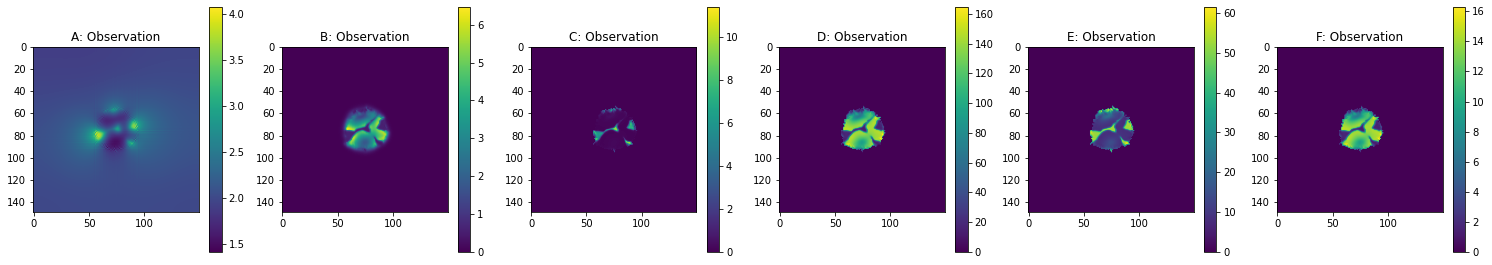

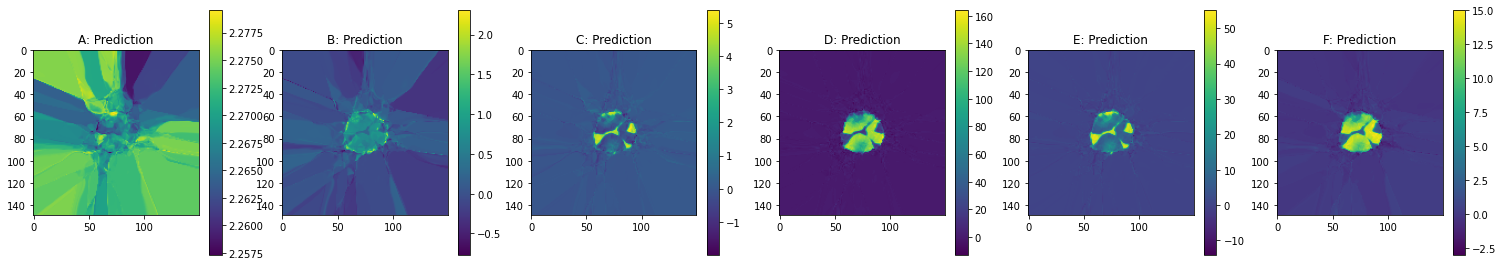

In [64]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [65]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)

T_test_index = -1
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N x 1
YY_test = Y_test.flatten()  # N x 1
TT_test = np.repeat(t_star[T_test_index], N)  # 1 x N

118


In [66]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 
#for i in range(output_test.shape[0]):
#    output_test[i, :, :] = (output_test[i, :, :] + 1.0)*(maxs[i]-mins[i])/2.0 + mins[i]

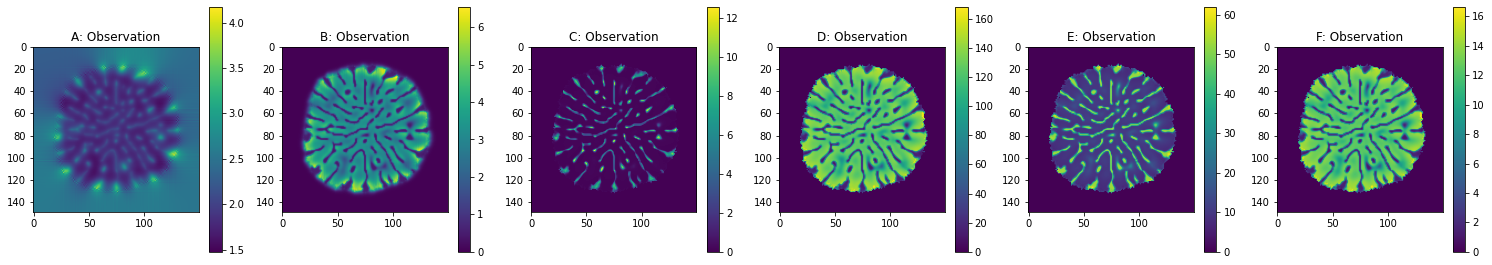

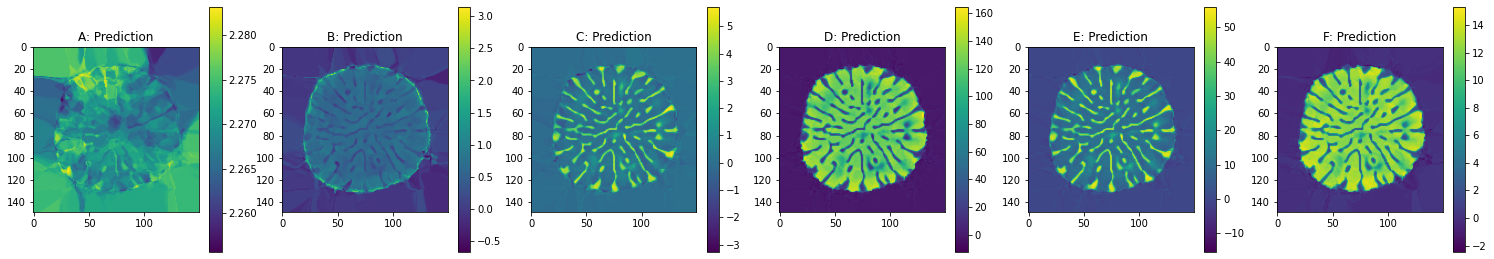

In [67]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Prediction")
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [78]:
model.optimizer.epsilon

1e-07

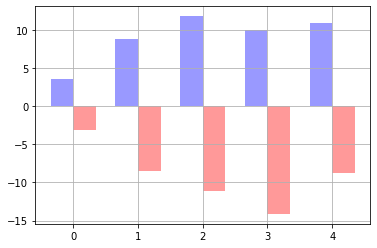

In [110]:
max_ws = np.zeros(len(pinn.Ws))
min_ws = np.zeros(len(pinn.Ws))
for i in range(len(pinn.Ws)):
    max_ws[i] = np.max(pinn.Ws[i].numpy())
    min_ws[i] = np.min(pinn.Ws[i].numpy())
    
index = np.arange(len(pinn.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

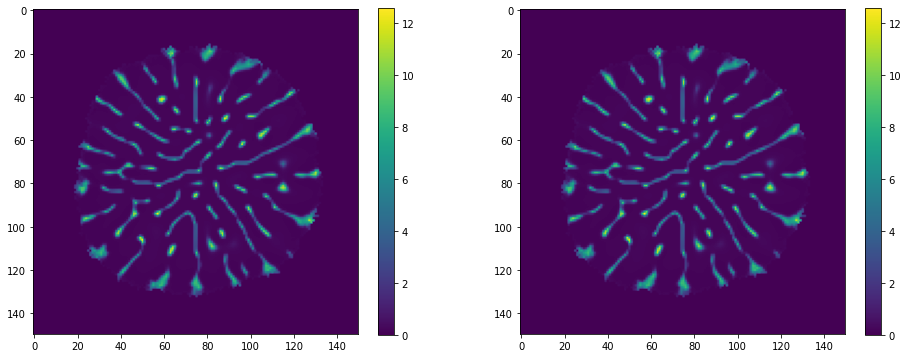

In [129]:
data_original = np.array(ds_1)
T_test_index = -1
_ = plt.figure(figsize=(2*8,8))
plt.subplot(121)
plt.imshow(mask[:, :, t_star[T_test_index]]*data_original[2,:, :, t_star[T_test_index]])
#plt.imshow(mask[:, :, t_star[T_test_index]])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data_original[2,:, :, t_star[T_test_index]]-np.min(data_original[2,:, :, t_star[T_test_index]]))
plt.colorbar(shrink=.75)
plt.show()

In [125]:
mask.shape

(150, 150, 120)